In [123]:
import pandas as pd
import numpy as np
import hotelling
from hotelling.plots import control_chart, control_stats, univariate_control_chart
from hotelling.stats import hotelling_t2
import scipy
import glob
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from scipy import stats

import pandas as pd
import glob
import collections
import random
import numpy as np
from multiprocessing import Pool    
import functools
from collections import defaultdict
import os
import sys
import multiprocessing
import time
from functools import partial
import argparse
from tqdm import tqdm

In [3]:
def abs_path(target_name, directory_level): 
    """
Returns absolute file path of target name in working directory.

Arguments:
    target_name (str): Name of file or folder to find.
    directory_level (str): Level of os search, either File or Folder.   
    """
    #Find the relative working directory of the script
    wk_dir = os.path.dirname(os.path.realpath('__file__'))
    
    if directory_level == "File":
        #Absolute file path
        for root, dirs, files in os.walk(wk_dir):
            for name in files:
                if target_name == name:
                    target_path = (os.path.abspath(os.path.join(root, name))) 
             
    #Absolute file path
    if directory_level == "Directory":
        for root, dirs, files in os.walk(wk_dir):
            for name in dirs:
                if target_name == name:
                    target_path = (os.path.abspath(os.path.join(root, name))) 
    
    return target_path



def count_kmers(data, k):
    """
Count kmers in a sequence. Outputs dictionary.

Arguments:
    data (str): Input sequence.
    k (int): Length of k-mer.
    """
    global d
    d = collections.defaultdict(int)
    for i in range(len(data)-(k-1)):
        d[data[i:i+k]] +=1
    for key in list(d.keys()):
        if "N" in key:
            del d[key]
    return d
 
    

def read_fasta(fp):
    """
Reads fasta file. Outputs sequence.

Arguments:
    fp (str): Input fasta file. 
    """  
    name, seq = None, []
    for line in fp:
        line = line.rstrip()
        if line.startswith(">"):
            if name: yield (name, ''.join(seq))
            name, seq = line, []
        else:
            seq.append(line)
    if name: yield (name, ''.join(seq))





def seq_slice(sequence_abs_path, slice_start="all", slice_end="all"):
    """
Set slice of genome sequence (inclusive of start and end of slice) as a string (high memory cost...)

Arguments:
    sequence_abs_path (str): Absolute path of sequence
    slice_start (int): Start of string slice
    slice_end (int): End of string slice, inclusive
    """
    
    if slice_start == "all" and slice_end == "all":
        
        with open(sequence_abs_path) as fp:
            for name, seq in read_fasta(fp):
                sequence = str(seq)
                sample = sequence[:]
        
        return sample
    
    else:
        
        with open(sequence_abs_path) as fp:
            for name, seq in read_fasta(fp):
                sequence = str(seq)
                sample = sequence[int(slice_start):int(slice_end)]
        
        return sample

"""
Codon dictionary
"""
codon_dict = { 
       "CYS": ["TGT", "TGC"], 
       "ASP": ["GAT", "GAC"], 
       "SER": ["TCT", "TCG", "TCA", "TCC", "AGC", "AGT"], 
       "GLN": ["CAA", "CAG"], 
       "MET": ["ATG"], 
       "ASN": ["AAC", "AAT"], 
       "PRO": ["CCT", "CCG", "CCA", "CCC"], 
       "LYS": ["AAG", "AAA"], 
       "STOP": ["TAG", "TGA", "TAA"], 
       "THR": ["ACC", "ACA", "ACG", "ACT"], 
       "PHE": ["TTT", "TTC"], 
       "ALA": ["GCA", "GCC", "GCG", "GCT"], 
       "GLY": ["GGT", "GGG", "GGA", "GGC"], 
       "ILE": ["ATC", "ATA", "ATT"], 
       "LEU": ["TTA", "TTG", "CTC", "CTT", "CTG", "CTA"], 
       "HIS": ["CAT", "CAC"], 
       "ARG": ["CGA", "CGC", "CGG", "CGT", "AGG", "AGA"], 
       "TRP": ["TGG"], 
       "VAL": ["GTA", "GTC", "GTG", "GTT"], 
       "GLU": ["GAG", "GAA"], 
       "TYR": ["TAT", "TAC"]} 

"List of Cancer Types in PCAWG Dataset"
cancer_type_list = ['Biliary-AdenoCA',
 'Bladder-TCC',
 'Bone-Benign',
 'Bone-Epith',
 'Bone-Osteosarc',
 'Breast-AdenoCA',
 'Breast-DCIS',
 'Breast-LobularCA',
 'CNS-GBM',
 'CNS-Medullo',
 'CNS-Oligo',
 'CNS-PiloAstro',
 'Cervix-AdenoCA',
 'Cervix-SCC',
 'ColoRect-AdenoCA',
 'Eso-AdenoCA',
 'Head-SCC',
 'Kidney-ChRCC',
 'Kidney-RCC',
 'Liver-HCC',
 'Lung-AdenoCA',
 'Lung-SCC',
 'Lymph-BNHL',
 'Lymph-CLL',
 'Myeloid-AML',
 'Myeloid-MDS',
 'Myeloid-MPN',
 'Ovary-AdenoCA',
 'Panc-AdenoCA',
 'Panc-Endocrine',
 'Prost-AdenoCA',
 'Skin-Melanoma',
 'SoftTissue-Leiomyo',
 'SoftTissue-Liposarc',
 'Stomach-AdenoCA',
 'Thy-AdenoCA',
 'Uterus-AdenoCA']


def syn_codon_dict(codon_dict):
    """
Synonymous codon dictionary

Arguments:
    codon_dict (dict)
    """
    syn_codon_dict = {}
    for codon_set in list(codon_dict.values()):
        for codon in codon_set:
            syn_codon = codon_set[:]  
            syn_codon.remove(codon)
            syn_codon_dict.setdefault(codon, syn_codon)
    return syn_codon_dict
    


def ref_data(input_name, num=False, prop=False):
    """
Reads in reference datasets from PCAWG studies.

Arguments:
    input_name (str): Name of csv file 
    num (bool): Set true to return dataframe of PCAWG SigProfiler Signatures in Samples 
    prop (bool): Set true to return dataframe of SigProfiler Signature Contributions
    
Note: Must set only one of num or prop arguments to True. 
    """
    if prop == num:
        raise ValueError("Please set only one argument between the arguments num and prop to True.")
        
    if num is True:
        
        num_file_path = abs_path(input_name, "File")
        num_data = pd.read_csv(num_file_path)
        num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
        num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)
        
        return num_data

    if prop is True:
            
        prop_file_path = abs_path(input_name, "File")
        prop_data = pd.read_csv(prop_file_path)
        
        return prop_data
    


def kmer_ref_count(kmer_length_start, kmer_length_end, ref_seq_name = "GRCh38.p13.genome.fasta", output_directory = "kmer_ref_count"):
    """
Count number of kmers of specified length in a fasta sequence. 
Used to count number of kmers in GChr.38

Arguments:
    kmer_length_start (int): Start counting kmers at this index
    kmer_length_end (int): Stop counting kmers at this index
    ref_seq_name (str): Name of file to count kmers from, default is the reference genome "GRCh38.p13.genome.fasta"
    output_directory (str): Name of folder to output kmer counts, default is the folder "kmer_ref_count"
    """
    input_file_path = abs_path(ref_seq_name, "File")
    
    with open(input_file_path) as fp:
        for name, seq in read_fasta(fp):
            for kmer_length in list(range(kmer_length_start, kmer_length_end+1)):
         
                count_kmers((str(seq)), kmer_length)
                count_df = pd.DataFrame.from_dict(d.keys())
                count_df['count'] = d.values()
                count_df.columns = [str(kmer_length), 'count']
        
                count_file_path = abs_path(output_directory, "Directory") + "/" + str(kmer_length)+'-mer_' + name + '.csv'
            
                with open(count_file_path, 'w'):
                    count_df.to_csv(count_file_path)
                    

#Cell 1 Loaded
print("Cell 1 of 5 Loaded")

#%%

"""
Input sequence file path
"""
#input_file_path = abs_path("Homo_sapiens.GRCh38.dna.chromosome.22.fasta", "File")

sig_weights =  pd.read_csv(abs_path("timelines_sigWeights.txt", "File"), sep='\t')
"""
Read in input reference files:
data = Pandas Dataframe of number of mutations attributed to each signature for each sample.
cancer_type = List of unique cancer types.
prop_data = Pandas Dataframe of proportion of 96 type mutation classification for each signature.
"""

"""
SBS input reference files
"""
sbs_num_file_path = abs_path("PCAWG_sigProfiler_SBS_signatures_in_samples.csv","File")
sbs_num_data = pd.read_csv(sbs_num_file_path)
sbs_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
sbs_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

sbs_prop_file_path = abs_path("sigProfiler_SBS_signatures.csv","File")
sbs_prop_data = pd.read_csv(sbs_prop_file_path)
  

"""
DBS input reference files
"""
dbs_num_file_path = abs_path("PCAWG_sigProfiler_DBS_signatures_in_samples.csv","File")
dbs_num_data = pd.read_csv(dbs_num_file_path)
dbs_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
dbs_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

dbs_prop_file_path = abs_path("sigProfiler_DBS_signatures.csv","File")
dbs_prop_data = pd.read_csv(dbs_prop_file_path)


"""
Insertion/Deletion input reference files
"""
id_num_file_path = abs_path("PCAWG_SigProfiler_ID_signatures_in_samples.csv","File")
id_num_data = pd.read_csv(id_num_file_path)
id_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
id_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

id_prop_file_path = abs_path("sigProfiler_ID_signatures.csv","File")
id_prop_data = pd.read_csv(id_prop_file_path)


#Cell 2 Loaded
print("Cell 2 of 5 Loaded")


#%%

def sig_proportion(cancer_type, num_data, std_outlier):
    """
Find the proportions of different combinations of signatures among all samples
Output proportion of samples with each combination of signatures. 

Arguments:
    cancer_type (str): Cancer type 
    num_data (dataframe): Signature data
    std_outlier (float): Parameter to exclude outliers by degrees of standard deviation 
    """
    #Setup dataframe with signature data
    n_mutation_df = num_data.loc[cancer_type,"Sample Names":]
    n_mutation_df.set_index("Sample Names", inplace=True)
    del n_mutation_df['Accuracy']
    
    cols = n_mutation_df.columns
    
    #Find contributing signature combinations for each sequence
    sig_combos = list(n_mutation_df.apply(lambda x: x > 0).apply(lambda x: list(n_mutation_df.columns[x.values]), axis=1))
  
    #Find the set of unique contributing signature combinations 
    unique_sig_combos = [list(x) for x in set(tuple(x) for x in sig_combos)]
    
    
    #All outliers found for each sequence in no particular order
    net_outlier_sample = []
    
    for index in unique_sig_combos:
        combo_df = n_mutation_df[index][(n_mutation_df[index] != 0).all(1)]
        filter_combo_df = combo_df[~(np.abs(combo_df-combo_df.mean()) > (std_outlier*combo_df.std()))]

        for sig in index:
            net_outlier_sample.append(filter_combo_df[filter_combo_df[sig].isnull()].index.tolist())
    
    #Set of unique outlier sequences
    set_outlier = list(set(x for l in net_outlier_sample for x in l))
    
    #print("Removed the following outliers from the signature combination probability matrix:" + str(set_outlier))

    #Drop outlier sequences 
    n_mutation_df.drop(set_outlier,inplace=True)
    
    #Dataframe of the proportion of a set of signatures contribution out of all possible combinations
    bt=n_mutation_df.apply(lambda x: x > 0)
    
    sig_prop = ( bt.apply( lambda x: (cols[x.values]) , axis=1).value_counts() ) / len(bt)
    
    return sig_prop



def outlier_detection(cancer_type, num_data, std_outlier):
    """
Identifies outliers in the dataframe, returns list of outliers

Arguments;
    cancer_type (str): Cancer type
    num_data (dataframe): Signature data
    std_outlier: Parameter to exclude outliers by degrees of standard deviation 
    """ 
    #Setup dataframe with signature data
    n_mutation_df = num_data.loc[cancer_type,"Sample Names":]
    n_mutation_df.set_index("Sample Names", inplace=True)
    del n_mutation_df['Accuracy']
    
    #Find contributing signature combinations for each sequence
    sig_combos = list(n_mutation_df.apply(lambda x: x > 0).apply(lambda x: list(n_mutation_df.columns[x.values]), axis=1))
  
    #Find the set of unique contributing signature combinations 
    unique_sig_combos = [list(x) for x in set(tuple(x) for x in sig_combos)]
    
    #All outliers found for each sequence in no particular order
    net_outlier_sample = []
    
    for index in unique_sig_combos:
        combo_df = n_mutation_df[index][(n_mutation_df[index] != 0).all(1)]
        filter_combo_df = combo_df[~(np.abs(combo_df-combo_df.mean()) > (std_outlier*combo_df.std()))]

        for sig in index:
            net_outlier_sample.append(filter_combo_df[filter_combo_df[sig].isnull()].index.tolist())
    
    #Set of unique outlier sequences
    set_outlier = list(set(x for l in net_outlier_sample for x in l))
    
    return set_outlier


def sequence_index_dict(input_file_path, slice_start, slice_end, kmer_length = 6, count=False):
    """
Pre-processing of the sequence into dictionary of format {kmer: [index1, index2, index3]}
High memory cost, only use SomaticSiMu up to 50 million base pairs of simulation

Arguments:
    input_file_path (str): Input file path of sequence to be preprocessed
    slice_start (int): Start of sequence slice for preprocessing
    slice_end (int): End of sequence slice for preprocessing
    count (bool): True returns counts of sequence, False returns indexes of sequence
    """
    sample = seq_slice(input_file_path, slice_start, slice_end)
    
    sample_index_dict = defaultdict(list)
    
    for seq_len in range(0, len(sample)-kmer_length):
        if 'N' in sample[seq_len:seq_len+kmer_length]:
            pass
        
        else:
            sample_index_dict[str(sample[seq_len:seq_len+kmer_length])].append(seq_len)
            

    if count is True:
        sample_count_dict = {key: len(value) for key, value in sample_index_dict.items()}
        return sample_count_dict
    
    else:
        return sample_index_dict
    

    
#Cell 3 Loaded
print("Cell 3 of 5 Loaded")

#%%

def sbs_mutation_probability(mut_sigs_directory, input_file_path, cancer_type, sample_seq, k3mer_count_map, std_outlier=3, power=1):

    #Load dataset
    sbs_signature = sbs_prop_data.copy().iloc[:, 2:-2]
    sbs_signature_in_sample = sbs_num_data.copy()
    
    #Identify outliers 
    outlier = outlier_detection(cancer_type=cancer_type, num_data=sbs_num_data, std_outlier=std_outlier)
    
    #Subset dataset for cancer type
    cancer_signatures = sbs_signature_in_sample[sbs_signature_in_sample["Cancer Types"] == cancer_type]
    
    #Remove outliers 
    filtered_df = cancer_signatures[~cancer_signatures['Sample Names'].isin(outlier)].reset_index(drop=True).iloc[:, 3:]
    
    #Remove signatures not active in any sequence
    filtered_df = filtered_df.loc[:, (filtered_df != 0).any(axis=0)]
    
    #Calculate expected number of mutations
    expected_mutations_df = pd.DataFrame(index=range(96), columns=range(len(filtered_df)), data=0)
    
    for sequence in range(len(filtered_df)):
        for signature in filtered_df.columns:
            signature_burden = filtered_df.loc[sequence, signature]
            sbs_96 = signature_burden * sbs_signature.loc[:, signature]
            expected_mutations_df[sequence] += sbs_96
            
    #Normalize mutation rate to length of sequence 
    sample_expected_mutations_df = expected_mutations_df.div(3000000000/len(sample_seq))
    
    #Randomly sample one sequence from subset of dataset
    sequence_index = random.choices(list(sample_expected_mutations_df.columns))
    
    #Mutation counts to be simulated
    mutation_counts = sample_expected_mutations_df[sequence_index[0]]
   
    
    #Setup mutational probability dataframe
    mutation_probability_df = sbs_prop_data.copy().iloc[:, :2]
    mutation_probability_df["Probability"] = 0
    
    for mutation in range(len(mutation_probability_df)):
        
        count = mutation_counts[mutation]
        subtype = k3mer_count_map[mutation_probability_df.loc[mutation, "SubType"]]
        mutation_probability_df.loc[mutation, "Probability"] = count / subtype
        
    #SBS signatures simulated
    sbs_sigs_path = mut_sigs_directory + "/" + cancer_type + '_sbs_sigs.txt'
    with open(sbs_sigs_path , 'a+') as outfile:
        outfile.write(str(list(filtered_df.loc[sequence_index[0], :][filtered_df.loc[sequence_index[0], :] > 0].index)))
        outfile.write("\n")
        
    mutation_probability_df['Probability'] = mutation_probability_df['Probability'] * power
    return mutation_probability_df.sort_values(['SubType'])
    
    

def dbs_mutation_probability(mut_sigs_directory, input_file_path, cancer_type, sample_seq, k2mer_count_map, std_outlier=3, power=1):

    #Load dataset
    dbs_signature = dbs_prop_data.copy()
    dbs_signature_in_sample = dbs_num_data.copy()
    
    #Identify outliers 
    outlier = outlier_detection(cancer_type=cancer_type, num_data=dbs_num_data, std_outlier=std_outlier)
    
    #Subset dataset for cancer type
    cancer_signatures = dbs_signature_in_sample[dbs_signature_in_sample["Cancer Types"] == cancer_type]
    
    #Remove outliers 
    filtered_df = cancer_signatures[~cancer_signatures['Sample Names'].isin(outlier)].reset_index(drop=True).iloc[:, 3:]
    
    #Remove signatures not active in any sequence
    filtered_df = filtered_df.loc[:, (filtered_df != 0).any(axis=0)]
    
    #Calculate expected number of mutations
    expected_mutations_df = pd.DataFrame(index=range(78), columns=range(len(filtered_df)), data=0)
    
    for sequence in range(len(filtered_df)):
        for signature in filtered_df.columns:
            signature_burden = filtered_df.loc[sequence, signature]
            dbs_78 = signature_burden * dbs_signature.loc[:, signature]
            expected_mutations_df[sequence] += dbs_78
            
    #Normalize mutation rate to length of sequence 
    sample_expected_mutations_df = expected_mutations_df.div(3000000000/len(sample_seq))
    
    #Randomly sample one sequence from subset of dataset
    sequence_index = random.choices(list(sample_expected_mutations_df.columns))
    
    #Mutation counts to be simulated
    mutation_counts = sample_expected_mutations_df[sequence_index[0]]
    
    #Setup mutational probability dataframe
    mutation_probability_df = dbs_prop_data.copy().iloc[:, :1]
    mutation_probability_df["Probability"] = 0
    
    for mutation in range(len(mutation_probability_df)):
        
        count = mutation_counts[mutation]
        subtype = k2mer_count_map[mutation_probability_df.loc[mutation, "Mutation Type"][:2]]
        mutation_probability_df.loc[mutation, "Probability"] = count / subtype
        
    #DBS signatures simulated
    dbs_sigs_path = mut_sigs_directory + "/" + cancer_type + '_dbs_sigs.txt'
    with open(dbs_sigs_path , 'a+') as outfile:
        outfile.write(str(list(filtered_df.loc[sequence_index[0], :][filtered_df.loc[sequence_index[0], :] > 0].index)))
        outfile.write("\n")

    mutation_probability_df['Probability'] = mutation_probability_df['Probability'] * power
    return mutation_probability_df.sort_values(['Mutation Type'])
    
    
def indel_mutation_probability(mut_sigs_directory, input_file_path, cancer_type, sample_seq, k1mer_count_map, k2mer_count_map, k3mer_count_map, k4mer_count_map, k5mer_count_map, k6mer_count_map, std_outlier=3, power=1):

    #Load dataset
    id_signature = id_prop_data.copy()
    id_signature_in_sample = id_num_data.copy()
    
    #Identify outliers 
    outlier = outlier_detection(cancer_type=cancer_type, num_data=id_num_data, std_outlier=std_outlier)
    
    #Subset dataset for cancer type
    cancer_signatures = id_signature_in_sample[id_signature_in_sample["Cancer Types"] == cancer_type]
    
    #Remove outliers 
    filtered_df = cancer_signatures[~cancer_signatures['Sample Names'].isin(outlier)].reset_index(drop=True).iloc[:, 3:]
    
    #Remove signatures not active in any sequence
    filtered_df = filtered_df.loc[:, (filtered_df != 0).any(axis=0)]
    
    #Calculate expected number of mutations
    expected_mutations_df = pd.DataFrame(index=range(24), columns=range(len(filtered_df)), data=0)
    
    for sequence in range(len(filtered_df)):
        for signature in filtered_df.columns:
            signature_burden = filtered_df.loc[sequence, signature]
            indel_24 = signature_burden * id_signature.loc[:, signature]
            expected_mutations_df[sequence] += indel_24
            
    #Normalize mutation rate to length of sequence 
    sample_expected_mutations_df = expected_mutations_df.div(3000000000/len(sample_seq))
    
    #Randomly sample one sequence from subset of dataset
    sequence_index = random.choices(list(sample_expected_mutations_df.columns))
    
    #Mutation counts to be simulated
    mutation_counts = sample_expected_mutations_df[sequence_index[0]]
    
    #Setup mutational probability dataframe
    mutation_probability_df = id_prop_data.copy().iloc[:, :2]
    mutation_probability_df["Probability"] = 0
    
    
    for mutation in range(0, 24, 6):
        
        count = mutation_counts[mutation]
        subtype = k1mer_count_map[mutation_probability_df.loc[mutation, "Index"]]
        mutation_probability_df.loc[mutation, "Probability"] = count / subtype
       
    for mutation in range(1, 24, 6):
        
        count = mutation_counts[mutation]
        subtype = k2mer_count_map[mutation_probability_df.loc[mutation, "Index"]]
        mutation_probability_df.loc[mutation, "Probability"] = count / subtype
        
    for mutation in range(2, 24, 6):
        
        count = mutation_counts[mutation]
        subtype = k3mer_count_map[mutation_probability_df.loc[mutation, "Index"]]
        mutation_probability_df.loc[mutation, "Probability"] = count / subtype
    
    for mutation in range(3, 24, 6):
        
        count = mutation_counts[mutation]
        subtype = k4mer_count_map[mutation_probability_df.loc[mutation, "Index"]]
        mutation_probability_df.loc[mutation, "Probability"] = count / subtype
        
    for mutation in range(4, 24, 6):
        
        count = mutation_counts[mutation]
        subtype = k5mer_count_map[mutation_probability_df.loc[mutation, "Index"]]
        mutation_probability_df.loc[mutation, "Probability"] = count / subtype
        
    for mutation in range(5, 24, 6):
        
        count = mutation_counts[mutation]
        subtype = k6mer_count_map[mutation_probability_df.loc[mutation, "Index"]]
        mutation_probability_df.loc[mutation, "Probability"] = count / subtype
        
    #ID signatures simulated
    id_sigs_path = mut_sigs_directory + "/" + cancer_type + '_id_sigs.txt'
    with open(id_sigs_path , 'a+') as outfile:
        outfile.write(str(list(filtered_df.loc[sequence_index[0], :][filtered_df.loc[sequence_index[0], :] > 0].index)))
        outfile.write("\n")
        
    mutation_probability_df['Probability'] = mutation_probability_df['Probability'] * power
    return mutation_probability_df
    
    
#Cell 4 Loaded
print("Cell 4 of 5 Loaded")

Cell 1 of 5 Loaded
Cell 2 of 5 Loaded
Cell 3 of 5 Loaded
Cell 4 of 5 Loaded


# Count number of 3-mers in sequence

In [5]:
k3mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/Homo_sapiens.GRCh38.dna.chromosome.22.fasta", 
                                      slice_start=0, 
                                      slice_end=50818467, 
                                      kmer_length = 3, 
                                      count=True)

# Load in Chromosome 22 sequence

In [7]:
sample_seq = seq_slice(sequence_abs_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/Homo_sapiens.GRCh38.dna.chromosome.22.fasta", slice_start="all", slice_end="all")

# SBS-96 Mutation Counts for 326 samples of Liver-HCC from COSMIC

In [248]:
sbs_prop_data

Type SubType          SBS1          SBS2     SBS3      SBS4     SBS5  \
0   C>A     ACA  8.860000e-04  5.800000e-07  0.02080  0.042200  0.01200   
1   C>T     ACA  2.500000e-02  6.110000e-05  0.01420  0.008700  0.03260   
2   C>G     ACA  1.860000e-03  2.230000e-16  0.01970  0.006890  0.01010   
3   C>A     ACC  2.280000e-03  1.480000e-04  0.01650  0.033300  0.00944   
4   C>T     ACC  6.320000e-03  1.380000e-03  0.01240  0.004180  0.01790   
..  ...     ...           ...           ...      ...       ...      ...   
91  T>C     TTG  4.160000e-04  1.170000e-04  0.00693  0.001740  0.01270   
92  T>G     TTG  5.830000e-04  9.540000e-05  0.00805  0.002320  0.00694   
93  T>C     TTT  4.330000e-03  3.580000e-05  0.01390  0.000636  0.01850   
94  T>A     TTT  2.250000e-03  2.050000e-04  0.01300  0.005620  0.00875   
95  T>G     TTT  2.230000e-16  2.230000e-16  0.01050  0.000568  0.01350   

        SBS6         SBS7a         SBS7b  ...    SBS53         SBS54  \
0   0.000425  6.700000e-05  2.330000e-03  ...  0.00538  2.160000e-03   
1   0.064100  1.220000e-04  1.410000e-03  ...  0.00722  1.480000e-03   
2   0.000471  6.490000e-05  8.560000e-06  ...  0.00703  1.550000e-03   
3   0.000524  1.790000e-04  4.610000e-04  ...  0.00196  7.960000e-04   
4   0.022900  1.770000e-02  3.810000e-02  ...  0.00196  5.290000e-04   
..       ...           ...           ...  ...      ...           ...   
91  0.002130  3.190000e-04  3.810000e-03  ...  0.00472  8.840000e-02   
92  0.000324  2.230000e-16  1.350000e-03  ...  0.00615  7.690000e-03   
93  0.001740  8.120000e-04  2.970000e-03  ...  0.00219  1.250000e-02   
94  0.000426  7.980000e-04  2.220000e-16  ...  0.00508  7.450000e-18   
95  0.001010  8.290000e-05  1.770000e-03  ...  0.00705  4.990000e-04   

       SBS55     SBS56    SBS57    SBS58         SBS59     SBS60     SBS84  \
0   0.005880  0.012600  0.01230  0.05890  3.590000e-03  0.006150  0.003472   
1   0.005110  0.007400  0.03260  0.08050  3.920000e-03  0.002760  0.053886   
2   0.002850  0.000418  0.01540  0.02060  2.940000e-03  0.000377  0.006758   
3   0.002050  0.015700  0.00143  0.00675  2.370000e-03  0.000779  0.005007   
4   0.000233  0.000982  0.01290  0.00676  2.860000e-03  0.001340  0.042107   
..       ...       ...      ...      ...           ...       ...       ...   
91  0.004160  0.001850  0.00296  0.00216  1.350000e-03  0.000109  0.000022   
92  0.079500  0.000101  0.00540  0.00674  1.960000e-03  0.023900  0.000000   
93  0.000887  0.000285  0.19500  0.03200  2.610000e-03  0.001320  0.009821   
94  0.002100  0.000744  0.02890  0.01460  2.990000e-03  0.000530  0.007060   
95  0.041200  0.029000  0.11900  0.02170  1.300000e-17  0.031800  0.006603   

       SBS85  
0   0.006080  
1   0.001375  
2   0.007235  
3   0.000880  
4   0.001478  
..       ...  
91  0.003824  
92  0.003410  
93  0.094054  
94  0.062798  
95  0.012709  

[96 rows x 69 columns]

In [287]:
sbs_num_data

Cancer Types Sample Names  Accuracy  SBS1  SBS2  SBS3  \
Cancer Types                                                                
Biliary-AdenoCA  Biliary-AdenoCA     SP117655     0.968  1496  1296     0   
Biliary-AdenoCA  Biliary-AdenoCA      SP99317     0.945    81     0     0   
Biliary-AdenoCA  Biliary-AdenoCA      SP99321     0.981   907     0     0   
Biliary-AdenoCA  Biliary-AdenoCA      SP99329     0.959   446   207  4741   
Biliary-AdenoCA  Biliary-AdenoCA      SP99333     0.966   328     0     0   
...                          ...          ...       ...   ...   ...   ...   
Uterus-AdenoCA    Uterus-AdenoCA      SP89443     0.994   688  1903     0   
Uterus-AdenoCA    Uterus-AdenoCA      SP89651     0.987   628    55     0   
Uterus-AdenoCA    Uterus-AdenoCA      SP94060     0.988   884   582     0   
Uterus-AdenoCA    Uterus-AdenoCA      SP92723     0.977   978     0     0   
Uterus-AdenoCA    Uterus-AdenoCA      SP95550     0.985   837   578     0   

                 SBS4  SBS5  SBS6  SBS7a  ...  SBS51  SBS52  SBS53  SBS54  \
Cancer Types                              ...                               
Biliary-AdenoCA     0  1825     0      0  ...      0      0      0      0   
Biliary-AdenoCA     0   727     0      0  ...      0      0      0      0   
Biliary-AdenoCA     0   751     0      0  ...      0      0      0      0   
Biliary-AdenoCA     0   707     0      0  ...      0      0      0      0   
Biliary-AdenoCA     0  1185     0      0  ...      0      0      0      0   
...               ...   ...   ...    ...  ...    ...    ...    ...    ...   
Uterus-AdenoCA      0  1110     0      0  ...      0      0      0      0   
Uterus-AdenoCA      0  1060     0      0  ...      0      0      0      0   
Uterus-AdenoCA      0  1228     0      0  ...      0      0      0      0   
Uterus-AdenoCA      0  1180     0      0  ...      0      0      0      0   
Uterus-AdenoCA      0  1434     0      0  ...      0      0      0      0   

                 SBS55  SBS56  SBS57  SBS58  SBS59  SBS60  
Cancer Types                                               
Biliary-AdenoCA      0      0      0      0      0      0  
Biliary-AdenoCA      0      0      0      0      0      0  
Biliary-AdenoCA      0      0      0      0      0      0  
Biliary-AdenoCA      0      0      0      0      0      0  
Biliary-AdenoCA      0      0      0      0      0      0  
...                ...    ...    ...    ...    ...    ...  
Uterus-AdenoCA       0      0      0      0      0      0  
Uterus-AdenoCA       0      0      0      0      0      0  
Uterus-AdenoCA       0      0      0      0      0      0  
Uterus-AdenoCA       0      0      0      0      0      0  
Uterus-AdenoCA       0      0      0      0      0      0  

[2780 rows x 68 columns]

In [249]:
sbs_prop_data.sort_values(['SubType'], inplace=True)
sbs_prop_data.reset_index(inplace=True, drop=True)

outlier = outlier_detection(cancer_type="Liver-HCC", num_data=sbs_num_data, std_outlier=10)

test = sbs_num_data[sbs_num_data["Cancer Types"] == "Liver-HCC"]
test[~test['Sample Names'].isin(outlier)]

filtered_df = test[~test['Sample Names'].isin(outlier)].reset_index(drop=True).iloc[:, 3:]

real_liver = pd.DataFrame(index=range(96), columns=range(len(filtered_df)), data=0)

for sequence in range(len(filtered_df)):
    
    for signature in filtered_df.columns:
        
        signature_burden = filtered_df.loc[sequence, signature]
        
        sbs_96 = signature_burden * sbs_prop_data.loc[:, signature]
        
        real_liver[sequence] += sbs_96

In [288]:
sbs_prop_data

Type SubType          SBS1          SBS2     SBS3      SBS4     SBS5  \
0   C>A     ACA  8.860000e-04  5.800000e-07  0.02080  0.042200  0.01200   
1   C>T     ACA  2.500000e-02  6.110000e-05  0.01420  0.008700  0.03260   
2   C>G     ACA  1.860000e-03  2.230000e-16  0.01970  0.006890  0.01010   
3   C>A     ACC  2.280000e-03  1.480000e-04  0.01650  0.033300  0.00944   
4   C>T     ACC  6.320000e-03  1.380000e-03  0.01240  0.004180  0.01790   
..  ...     ...           ...           ...      ...       ...      ...   
91  T>A     TTG  2.800000e-05  5.010000e-05  0.00671  0.009540  0.00479   
92  T>G     TTG  5.830000e-04  9.540000e-05  0.00805  0.002320  0.00694   
93  T>A     TTT  2.250000e-03  2.050000e-04  0.01300  0.005620  0.00875   
94  T>C     TTT  4.330000e-03  3.580000e-05  0.01390  0.000636  0.01850   
95  T>G     TTT  2.230000e-16  2.230000e-16  0.01050  0.000568  0.01350   

        SBS6         SBS7a         SBS7b  ...    SBS53         SBS54  \
0   0.000425  6.700000e-05  2.330000e-03  ...  0.00538  2.160000e-03   
1   0.064100  1.220000e-04  1.410000e-03  ...  0.00722  1.480000e-03   
2   0.000471  6.490000e-05  8.560000e-06  ...  0.00703  1.550000e-03   
3   0.000524  1.790000e-04  4.610000e-04  ...  0.00196  7.960000e-04   
4   0.022900  1.770000e-02  3.810000e-02  ...  0.00196  5.290000e-04   
..       ...           ...           ...  ...      ...           ...   
91  0.000029  2.230000e-16  1.700000e-03  ...  0.00160  3.290000e-04   
92  0.000324  2.230000e-16  1.350000e-03  ...  0.00615  7.690000e-03   
93  0.000426  7.980000e-04  2.220000e-16  ...  0.00508  7.450000e-18   
94  0.001740  8.120000e-04  2.970000e-03  ...  0.00219  1.250000e-02   
95  0.001010  8.290000e-05  1.770000e-03  ...  0.00705  4.990000e-04   

       SBS55     SBS56    SBS57     SBS58         SBS59     SBS60     SBS84  \
0   0.005880  0.012600  0.01230  0.058900  3.590000e-03  0.006150  0.003472   
1   0.005110  0.007400  0.03260  0.080500  3.920000e-03  0.002760  0.053886   
2   0.002850  0.000418  0.01540  0.020600  2.940000e-03  0.000377  0.006758   
3   0.002050  0.015700  0.00143  0.006750  2.370000e-03  0.000779  0.005007   
4   0.000233  0.000982  0.01290  0.006760  2.860000e-03  0.001340  0.042107   
..       ...       ...      ...       ...           ...       ...       ...   
91  0.009480  0.006360  0.00440  0.000829  4.530000e-04  0.000042  0.000784   
92  0.079500  0.000101  0.00540  0.006740  1.960000e-03  0.023900  0.000000   
93  0.002100  0.000744  0.02890  0.014600  2.990000e-03  0.000530  0.007060   
94  0.000887  0.000285  0.19500  0.032000  2.610000e-03  0.001320  0.009821   
95  0.041200  0.029000  0.11900  0.021700  1.300000e-17  0.031800  0.006603   

       SBS85  
0   0.006080  
1   0.001375  
2   0.007235  
3   0.000880  
4   0.001478  
..       ...  
91  0.006733  
92  0.003410  
93  0.062798  
94  0.094054  
95  0.012709  

[96 rows x 69 columns]

In [250]:
real_liver

0          1          2           3           4          5    \
0   261.045710  123.69600  399.26048  290.581718   97.115734   73.31200   
1   350.540250  309.64040  524.59934  289.844050  253.020740  130.85690   
2   110.942100   94.03190  165.45788  105.846800   76.943520   41.18240   
3   194.087663   87.84716  308.56832  217.287150   71.944260   58.28000   
4   191.154180  166.48610  289.05578  152.023800  136.554460   72.47210   
..         ...        ...        ...         ...         ...        ...   
91  137.342584   53.14181   85.92324   88.475394   40.565542   19.29934   
92   77.344265   64.75516  107.53740   62.257224   52.877757   27.48680   
93  139.699300   97.81625  156.20400  110.525960   74.657500   35.05450   
94  406.915732  396.35150  530.07498  420.057278  249.857670   73.41202   
95  142.500163  127.94550  213.17536  106.167294  103.721240   53.70548   

           6           7           8           9    ...         316  \
0   267.603114  106.335932  169.843908  181.662204  ...  392.826760   
1   345.607830  219.526540  194.342570  242.289250  ...  584.157810   
2   118.066430   69.200420   86.423620   76.475320  ...  184.195440   
3   198.340050   66.547580   90.144850  142.348510  ...  307.373370   
4   182.828200  123.553380  109.717100  133.807420  ...  322.828080   
..         ...         ...         ...         ...  ...         ...   
91   87.873172   41.782426   40.077414   37.941804  ...   91.016488   
92   73.378242   53.560236   60.549809   49.650447  ...  121.112615   
93  122.898990   73.150910  128.787750   68.932600  ...  165.349400   
94  474.866642  200.979400  176.778040  199.724116  ...  461.089844   
95  132.399266  113.049480  155.951370   97.960034  ...  238.428286   

           317         318         319         320         321         322  \
0    54.219568  147.607590  239.737702  521.162138   87.607190  344.336000   
1   147.614370  220.646980  255.685800  489.230902  138.432820  536.083400   
2    44.644520   73.353950  103.573682  229.907372   43.068620  178.335020   
3    41.802710  113.002500  144.793328  244.637358   68.179520  259.784240   
4    79.551100  117.301440  137.765680  282.546634   75.771180  288.008540   
..         ...         ...         ...         ...         ...         ...   
91   22.026144   48.230050   59.386570  131.305886   21.577412  116.672710   
92   30.590069   46.329695   68.861109  177.020846   28.431155  114.339500   
93   40.646000   69.343120  144.740312  394.516620   39.409850  173.078910   
94  107.598240  200.272786  243.523898  836.955560  116.324566  556.328148   
95   59.564370   84.132748  165.482024  585.847950   55.921384  211.134524   

           323         324         325  
0   245.860240  273.790556  275.644616  
1   310.111310  266.024590  232.091670  
2    97.175780  129.868340  116.920340  
3   186.396860  137.929310  126.440030  
4   169.563350  152.552500  135.092330  
..         ...         ...         ...  
91   53.955884   60.145838   64.398008  
92   63.005230   91.415063   87.665043  
93   98.375200  208.195750  207.432420  
94  403.952782  271.480080  375.811210  
95  125.788788  245.768990  242.635350  

[96 rows x 326 columns]

# SBS-96 Mutation Counts for 200 samples of simulated Liver-HCC

In [251]:
file_list = glob.glob('Frequency_Table/*sbs_freq_table.csv')
file_list = sorted(file_list)[1019:]
len(file_list)

200

In [253]:
simulated_liver = pd.DataFrame(index=range(96), columns=range(len(file_list)), data=0)
for file in file_list:
    simulated_liver[file_list.index(file)] = pd.read_csv(file).iloc[:,2]

In [254]:
simulated_liver

0    1    2    3    4    5    6    7    8    9    ...  190  191  192  193  \
0     4    3    1    3    1    1   10    7    4    5  ...    0    2    4    4   
1    10    6    3    5    6    2    4   13    0    3  ...    2    8    3    6   
2     2    1    1    2    3    1    4    0    1    2  ...    1    2    2    2   
3     4    2    2    2    1    4    2    4    2    5  ...    1    2    2    3   
4     3    2    1    5    3    1    8    6    1    2  ...    1    3    1    3   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
91    2    0    0    0    0    1    3    2    0    0  ...    0    1    2    0   
92    1    0    1    4    0    4    2    2    1    0  ...    0    0    2    2   
93    2    1    0    4    1    1    5    4    3    2  ...    2    3    8    0   
94    1    1    4    1    2    2    7    8    2    1  ...    4    1    8    2   
95    2    0    5    3    3    1    3    1    2    0  ...    1    3    5    2   

    194  195  196  197  198  199  
0     4    1    0    4    0    2  
1     3    7    2    5    0    8  
2     1    2    1    0    0    1  
3     1    3    4    4    0    0  
4     1    2    2    0    2    2  
..  ...  ...  ...  ...  ...  ...  
91    2    1    2    2    0    0  
92    1    2    0    1    0    2  
93    2    1    0    1    0    2  
94    0    4    1    1    0    2  
95    2    2    0    1    1    1  

[96 rows x 200 columns]

# Mean of each distribution for real (n=326) vs. simulated (n=200)

In [255]:
real_liver_mean = real_liver.div(real_liver.sum(axis=0), axis=1).mean(axis=1)

In [256]:
simulated_liver_mean = simulated_liver.div(simulated_liver.sum(axis=0), axis=1).mean(axis=1)

# Boxplot of SBS-96 Mutation Proportions for Real Data

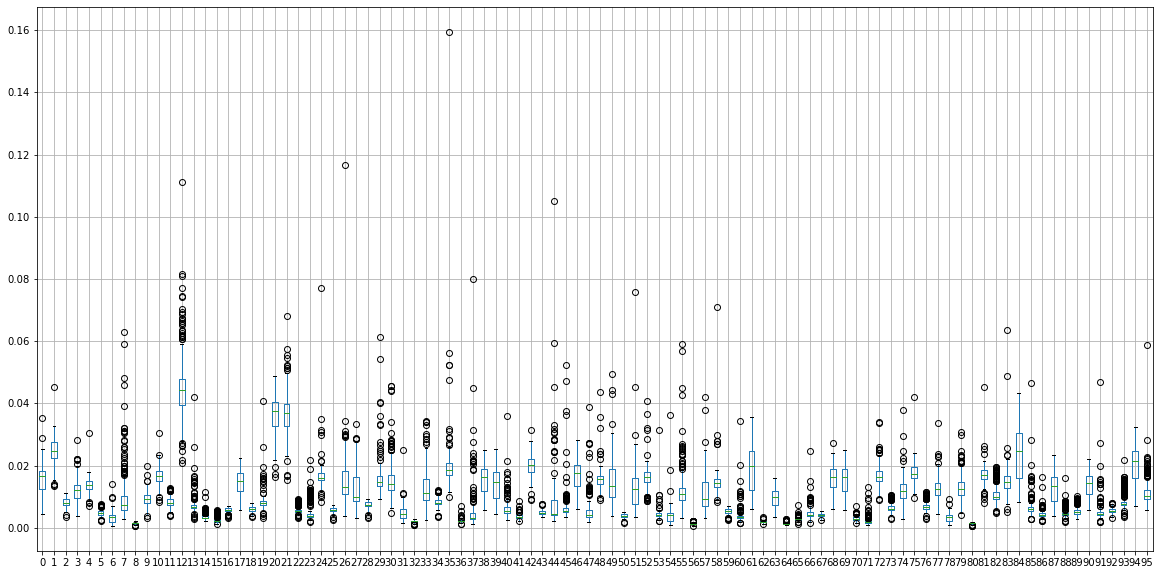

In [257]:
real_liver.div(real_liver.sum(axis=0), axis=1).T.boxplot(figsize=(20,10))

# Boxplot of SBS-96 Mutation Proportions for Simulated Data

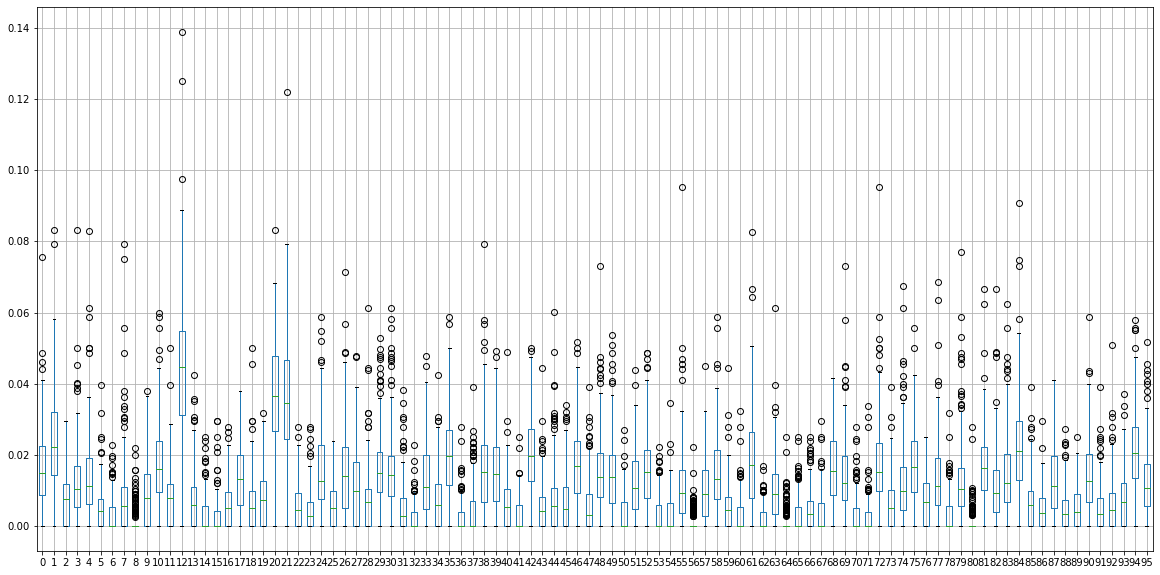

In [258]:
simulated_liver.div(simulated_liver.sum(axis=0), axis=1).T.boxplot(figsize=(20,10))

# Cosine Similarity of the Mean of the Real and Simulated Distributions

In [259]:
cosine_similarity([real_liver_mean.tolist(), simulated_liver_mean.tolist()])

array([[1.        , 0.99924123],
       [0.99924123, 1.        ]])

# Barplot of the Mean of SBS-96 Mutation Proportions for Real Data

<BarContainer object of 96 artists>

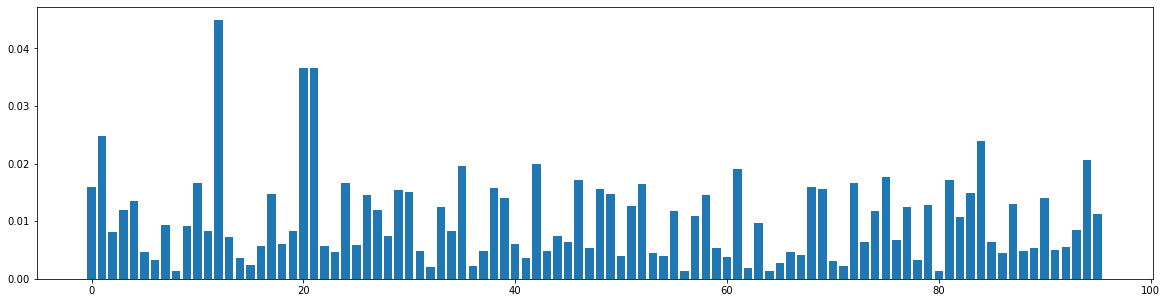

In [263]:
f, ax = plt.subplots(figsize=(20,5))
plt.bar(range(96), real_liver_mean.tolist())

In [292]:
unsort_index = list(pd.read_csv(sbs_prop_file_path).sort_values(['SubType']).index)

In [297]:
pd.read_csv(sbs_prop_file_path).sort_values(['SubType']).index

Int64Index([ 0, 32, 16,  1, 33, 17,  2, 34, 18,  3, 35, 19, 64, 48, 80, 81, 49,
            65, 82, 50, 66, 67, 51, 83, 36, 20,  4,  5, 21, 37, 38,  6, 22,  7,
            23, 39, 84, 52, 68, 69, 53, 85, 70, 86, 54, 87, 71, 55, 40,  8, 24,
             9, 41, 25, 10, 42, 26, 11, 43, 27, 56, 72, 88, 73, 89, 57, 58, 90,
            74, 75, 59, 91, 44, 28, 12, 45, 29, 13, 14, 46, 30, 47, 31, 15, 76,
            60, 92, 77, 61, 93, 78, 62, 94, 63, 79, 95],
           dtype='int64')

In [300]:
real_liver_mean

0     0.015862
1     0.024792
2     0.008163
3     0.011888
4     0.013586
        ...   
91    0.005072
92    0.005524
93    0.008422
94    0.020718
95    0.011265
Length: 96, dtype: float64

In [294]:
real_liver_mean.reindex(unsort_index)

0     0.015862
32    0.002050
16    0.005724
1     0.024792
33    0.012417
        ...   
62    0.001952
94    0.020718
63    0.009710
79    0.012781
95    0.011265
Length: 96, dtype: float64

In [436]:
#@title Function: Plot COSMIC SBS Signature
def sbs_sig_plot(cancer_type, signature):
    sns.set_style("white")
    #Set up the SBS-96 classification dataframe
    classification = pd.read_csv(sbs_prop_file_path).copy().iloc[:, :2]
    
    classification['signature'] = signature
    
    plt.rcParams['axes.linewidth'] = 1.5
    #Initialize figure plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    #96 axis ticks for SBS-96 classification scheme
    N = 96
    ind = np.arange(96)   

    #Colour list for patches 
    color_list = [(0.416, 0.733, 0.918), (0,0,0), (0.765, 0.172, 0.157), (0.785, 0.785, 0.785), (0.678, 0.808, 0.412), (0.878, 0.773, 0.769)]

    p1 = ax.bar(range(0,16), classification.iloc[0:16, 2], bottom=0, color = color_list[0])
    p2 = ax.bar(range(16,32), classification.iloc[16:32, 2], bottom=0, color = color_list[1])
    p3 = ax.bar(range(32,48), classification.iloc[32:48, 2], bottom=0, color = color_list[2])
    p4 = ax.bar(range(48,64), classification.iloc[48:64, 2], bottom=0, color = color_list[3])
    p5 = ax.bar(range(64,80), classification.iloc[64:80, 2], bottom=0, color = color_list[4])
    p6 = ax.bar(range(80,96), classification.iloc[80:96, 2], bottom=0, color = color_list[5])

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 15, y_limit/20, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((16, y_limit + y_limit/50), 15, y_limit/20, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((32, y_limit + y_limit/50), 15, y_limit/20, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((48, y_limit + y_limit/50), 15, y_limit/20, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((64, y_limit + y_limit/50), 15, y_limit/20, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((80, y_limit + y_limit/50), 15, y_limit/20, color = color_list[5], clip_on=False) 

    plt.text(6, y_limit + y_limit/9, "C>A", fontsize=20, weight="bold")
    plt.text(22, y_limit + y_limit/9, "C>G", fontsize=20, weight="bold")
    plt.text(38, y_limit + y_limit/9, "C>T", fontsize=20, weight="bold")
    plt.text(54, y_limit + y_limit/9, "T>A", fontsize=20, weight="bold")
    plt.text(70, y_limit + y_limit/9, "T>C", fontsize=20, weight="bold")
    plt.text(86, y_limit + y_limit/9, "T>G", fontsize=20, weight="bold")

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)

    ax.set_xlabel('Trinucleotide SubType', fontsize=15, weight="bold")
    ax.yaxis.set_label_text('Proportion of Single Base Substitutions', fontsize=15, weight="bold")

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['SubType'], fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    ax.set_title("Mutational Profile of " + str(cancer_type) + " COSMIC Mutational Signatures (v3.0)", pad=70, weight="bold", size=20)

    #ax.grid(axis = 'y', color=color_list[3], linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    plt.rcParams["figure.dpi"] = 600
    
    #counter = 0
    #mut_type_counter = 0
    #for i in range(96):
    #    plt.gca().get_xticklabels()[i].set_color(color_list[mut_type_counter]) 
    #    if counter == 15:
    #        counter = 0
    #        mut_type_counter += 1
    #    else:
    #        counter += 1
        
    plt.show()

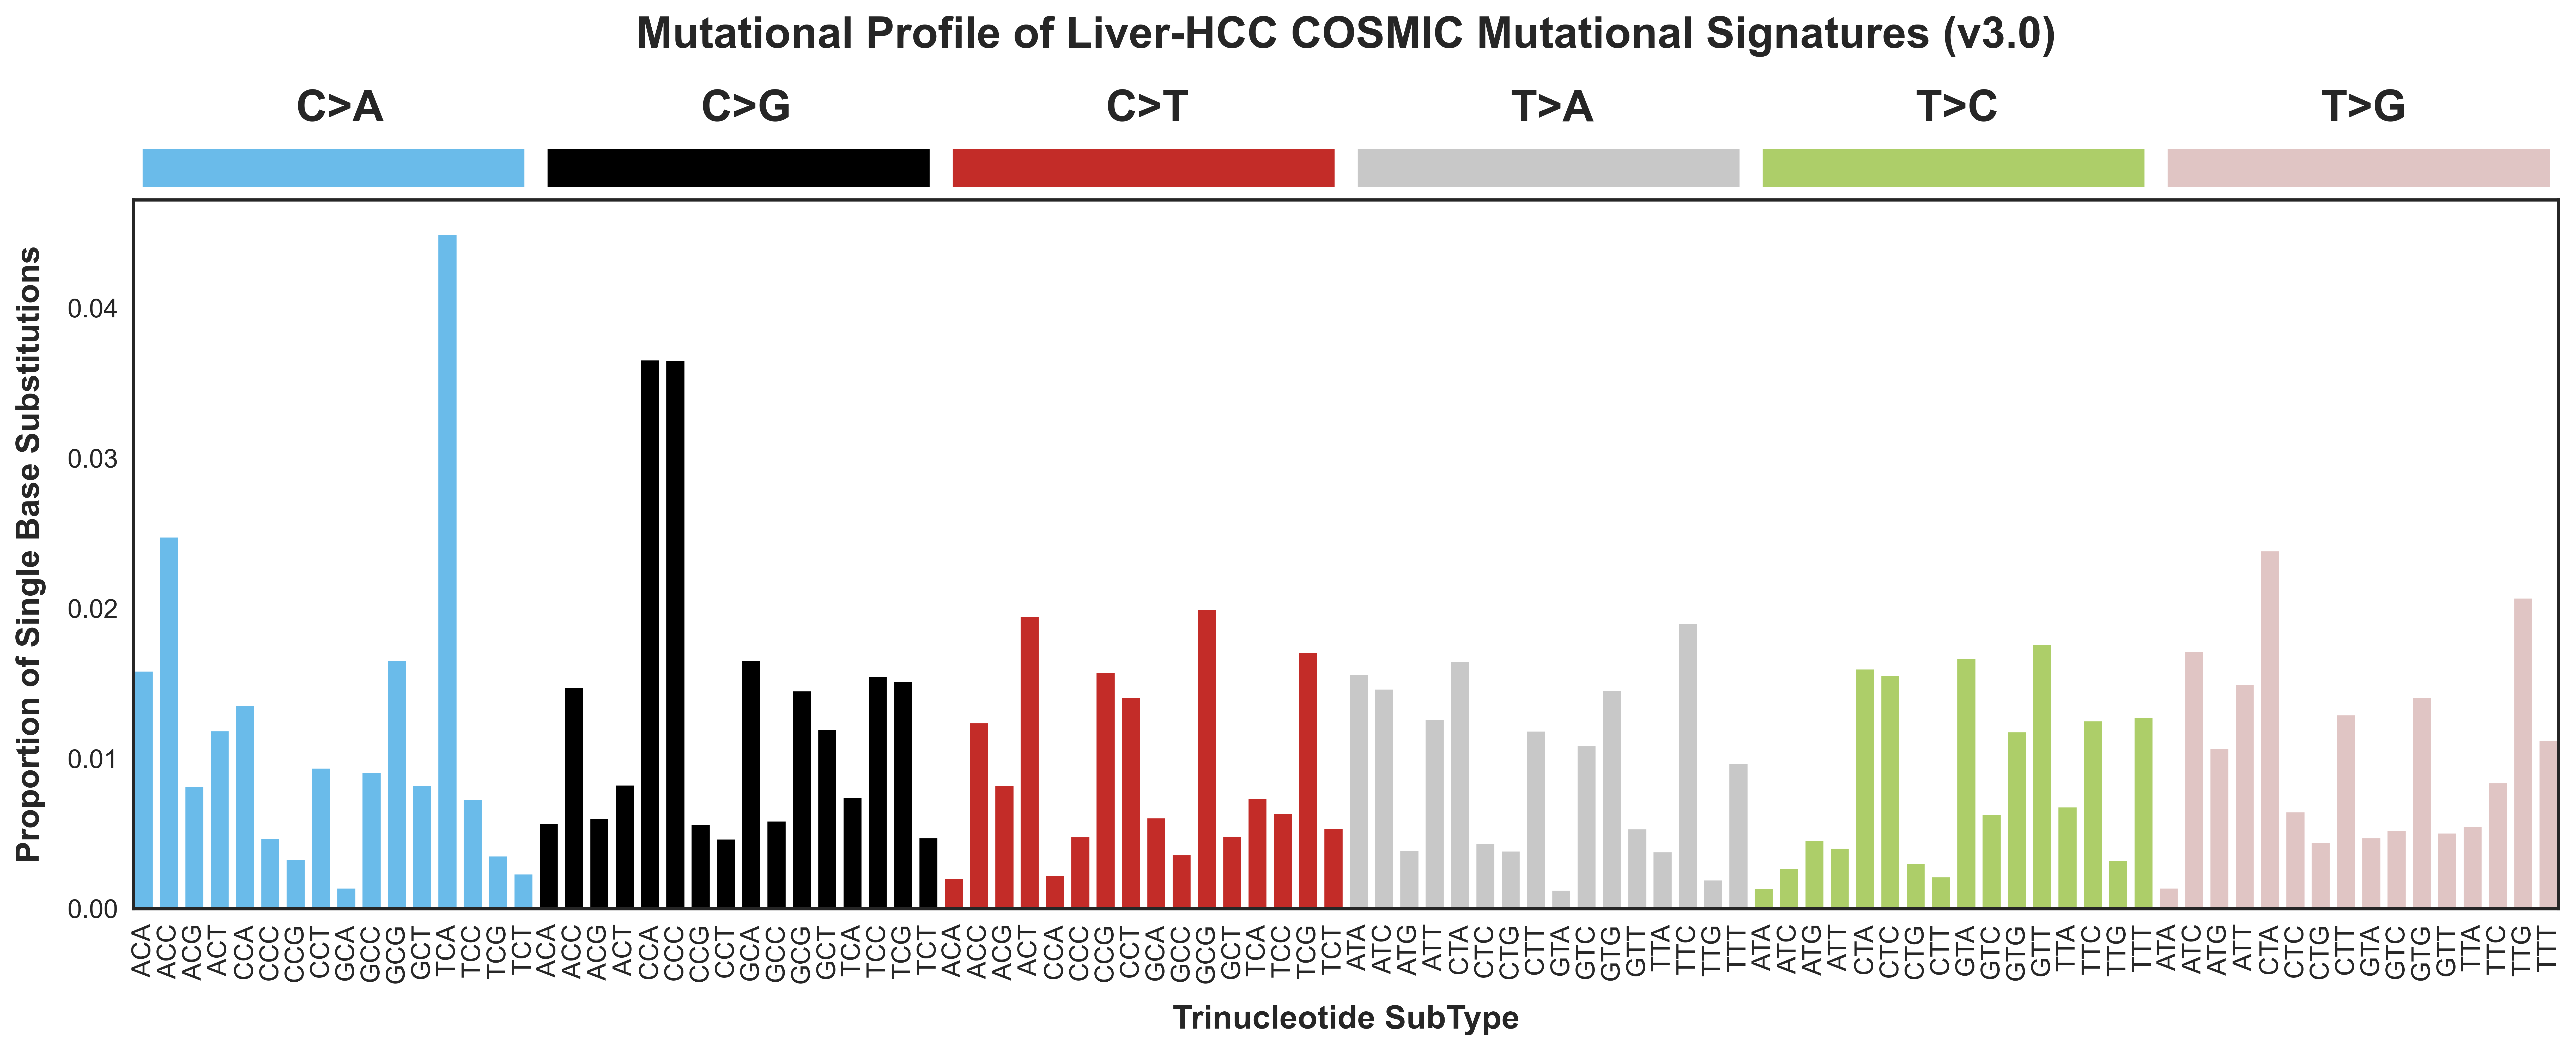

In [437]:
sbs_sig_plot(cancer_type = "Liver-HCC", signature=real_liver_mean)

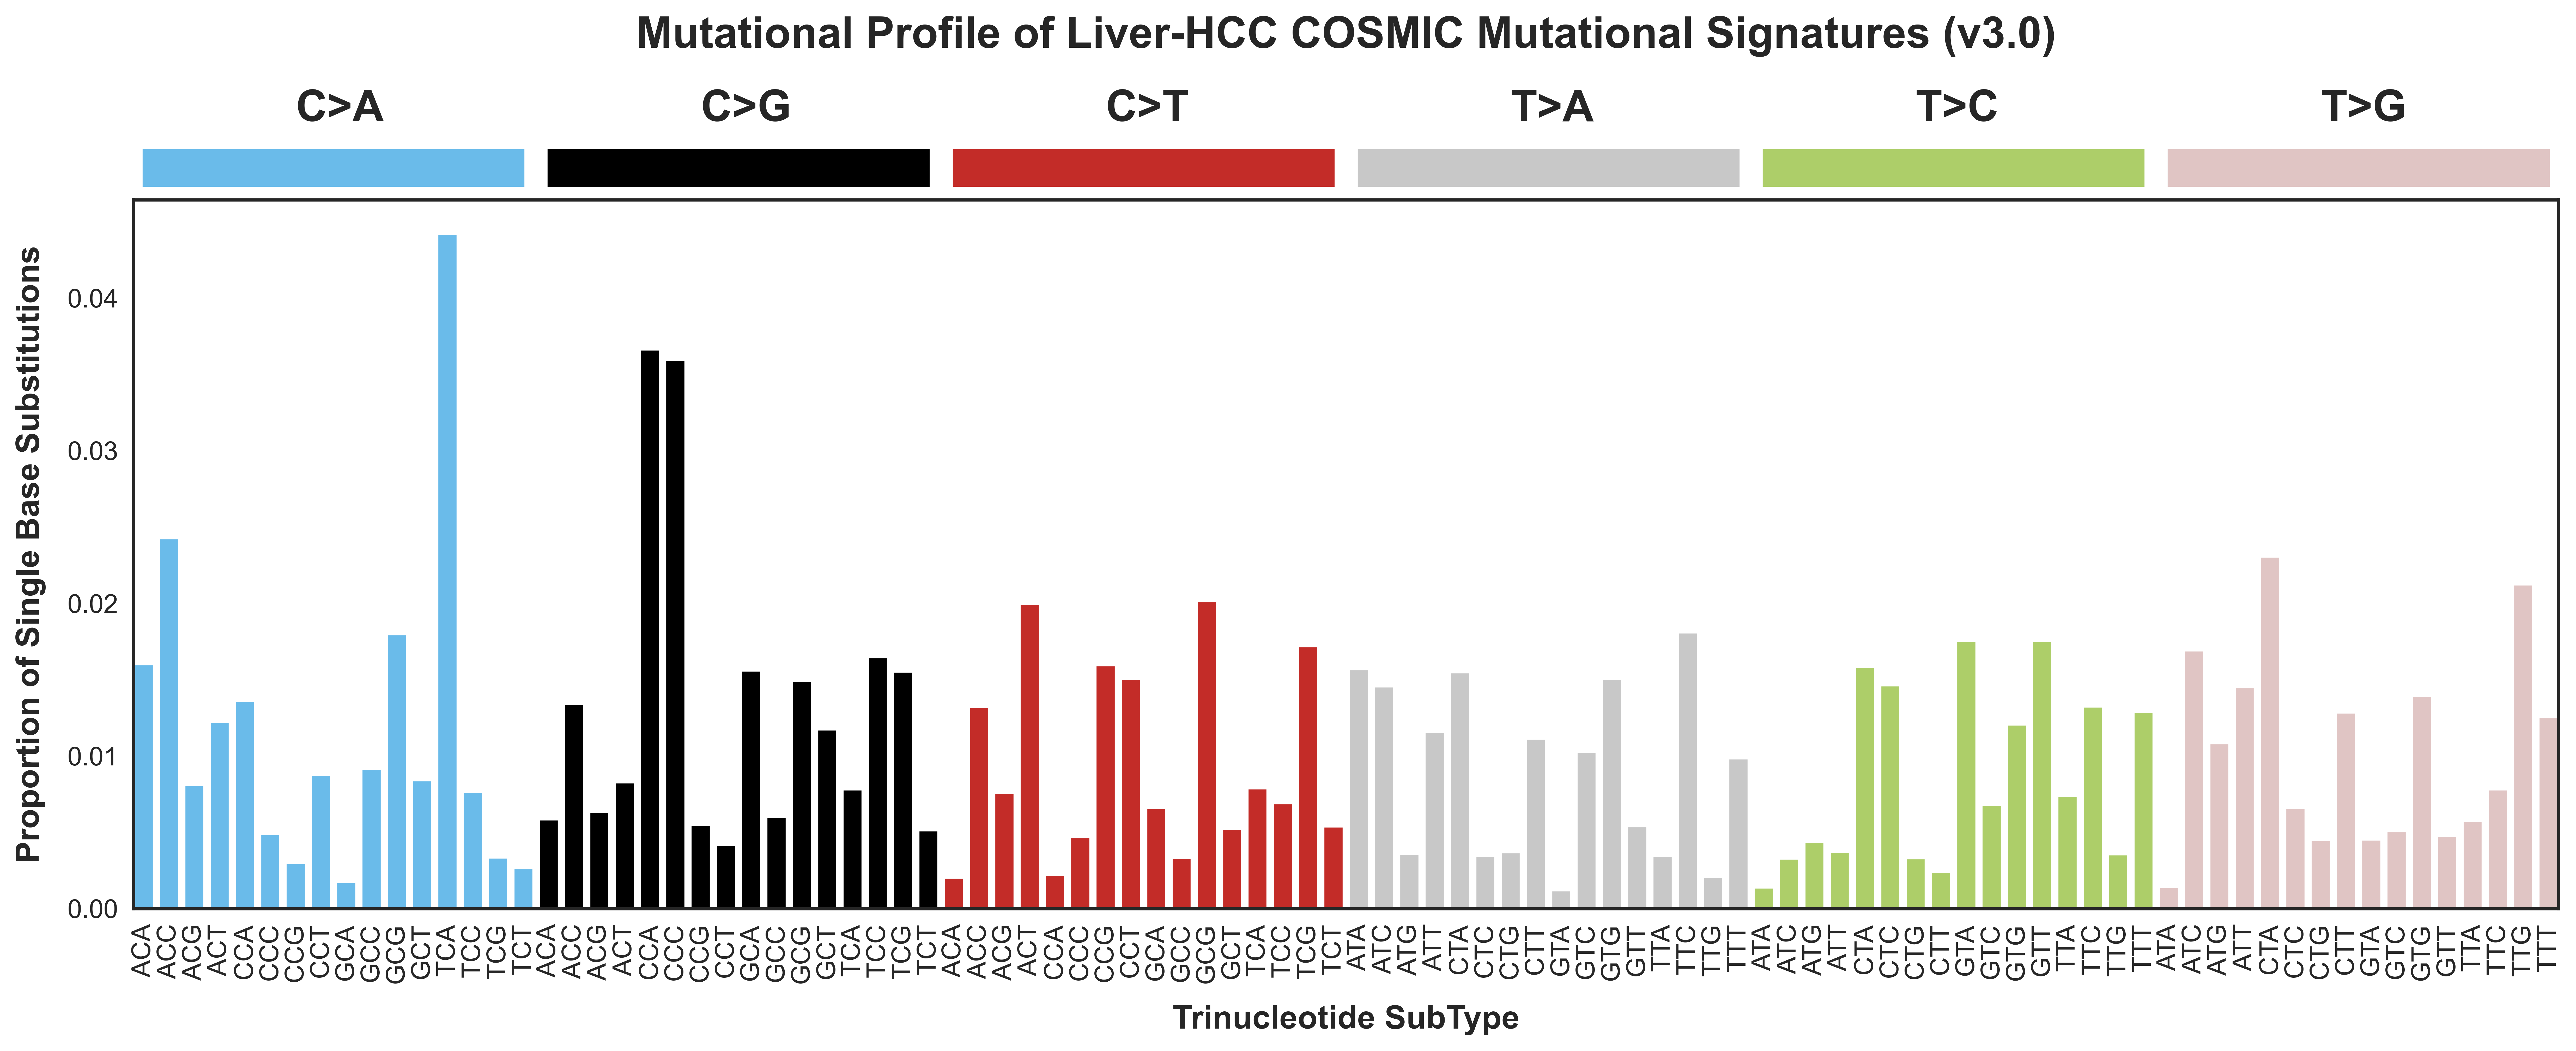

In [438]:
sbs_sig_plot(cancer_type = "Liver-HCC", signature=simulated_liver_mean)

In [439]:
#@title Function: Plot COSMIC DBS Signature
def dbs_sig_plot(cancer_type, signature):
    sns.set_style("whitegrid", {'axes.grid' : False})
    #Set up the DBS-78 classification dataframe
    classification = pd.read_csv(dbs_prop_file_path).copy().iloc[:, :1]
    
    classification['signature'] = signature
    plt.rcParams['axes.linewidth'] = 1.5
    #Initialize figure plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    #78 axis ticks for DBS-78 classification scheme
    N = 78
    ind = np.arange(78)   

    color_list = [(0.416, 0.733, 0.918), 
                  (0.227, 0.404, 0.773), 
                  (0.682, 0.796, 0.420), 
                  (0.224, 0.396, 0.0941), 
                  (0.906, 0.592, 0.592), 
                  (0.761, 0.173, 0.170),
                  (0.918, 0.686, 0.424),
                  (0.89, 0.502, 0.118),
                  (0.737, 0.588, 0.984),
                  (0.263, 0.0118, 0.584)]

    p1 = ax.bar(range(0,9), classification.iloc[0:9, -1], bottom=0, color = color_list[0])
    p2 = ax.bar(range(9,15), classification.iloc[9:15, -1], bottom=0, color = color_list[1])
    p3 = ax.bar(range(15,24), classification.iloc[15:24, -1], bottom=0, color = color_list[2])
    p4 = ax.bar(range(24,30), classification.iloc[24:30, -1], bottom=0, color = color_list[3])
    p5 = ax.bar(range(30,39), classification.iloc[30:39, -1], bottom=0, color = color_list[4])
    p6 = ax.bar(range(39,45), classification.iloc[39:45, -1], bottom=0, color = color_list[5])
    p7 = ax.bar(range(45,51), classification.iloc[45:51, -1], bottom=0, color = color_list[6])
    p8 = ax.bar(range(51,60), classification.iloc[51:60, -1], bottom=0, color = color_list[7])
    p9 = ax.bar(range(60,69), classification.iloc[60:69, -1], bottom=0, color = color_list[8])
    p10 = ax.bar(range(69,78), classification.iloc[69:78, -1], bottom=0, color = color_list[9])

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((9, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((15, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((24, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((30, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((39, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[5], clip_on=False) 
    rect7 = patches.Rectangle((45, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[6], clip_on=False) 
    rect8 = patches.Rectangle((51, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[7], clip_on=False) 
    rect9 = patches.Rectangle((60, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[8], clip_on=False) 
    rect10 = patches.Rectangle((69, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[9], clip_on=False) 

    plt.text(2, y_limit + y_limit/9, "AC>NN", fontsize=20, weight="bold")
    plt.text(9.5, y_limit + y_limit/9, "AT>NN", fontsize=20, weight="bold")
    plt.text(17, y_limit + y_limit/9, "CC>NN", fontsize=20, weight="bold")
    plt.text(24.25, y_limit + y_limit/9, "CG>NN", fontsize=20, weight="bold")
    plt.text(31.75, y_limit + y_limit/9, "CT>NN", fontsize=20, weight="bold")
    plt.text(39.25, y_limit + y_limit/9, "GC>NN", fontsize=20, weight="bold")
    plt.text(45.5, y_limit + y_limit/9, "TA>NN", fontsize=20, weight="bold")
    plt.text(53, y_limit + y_limit/9, "TC>NN", fontsize=20, weight="bold")
    plt.text(61.5, y_limit + y_limit/9, "TG>NN", fontsize=20, weight="bold")
    plt.text(71, y_limit + y_limit/9, "TT>NN", fontsize=20, weight="bold")        

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)
    ax.add_patch(rect7)
    ax.add_patch(rect8)
    ax.add_patch(rect9)
    ax.add_patch(rect10)

    ax.set_xlabel('Doublet SubType', fontsize=15, weight="bold")
    ax.yaxis.set_label_text('Percentage of Double Base Substitutions', fontsize=15, weight="bold")

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['Mutation Type'].str[3:], fontsize=8)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    ax.set_title("Mutational Profile of " + str(cancer_type) + " COSMIC Mutational Signatures (v3.0)", pad=70, weight="bold", size=20)

    #ax.grid(axis = 'y', color=(0.785, 0.785, 0.785), linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    plt.rcParams["figure.dpi"] = 600
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

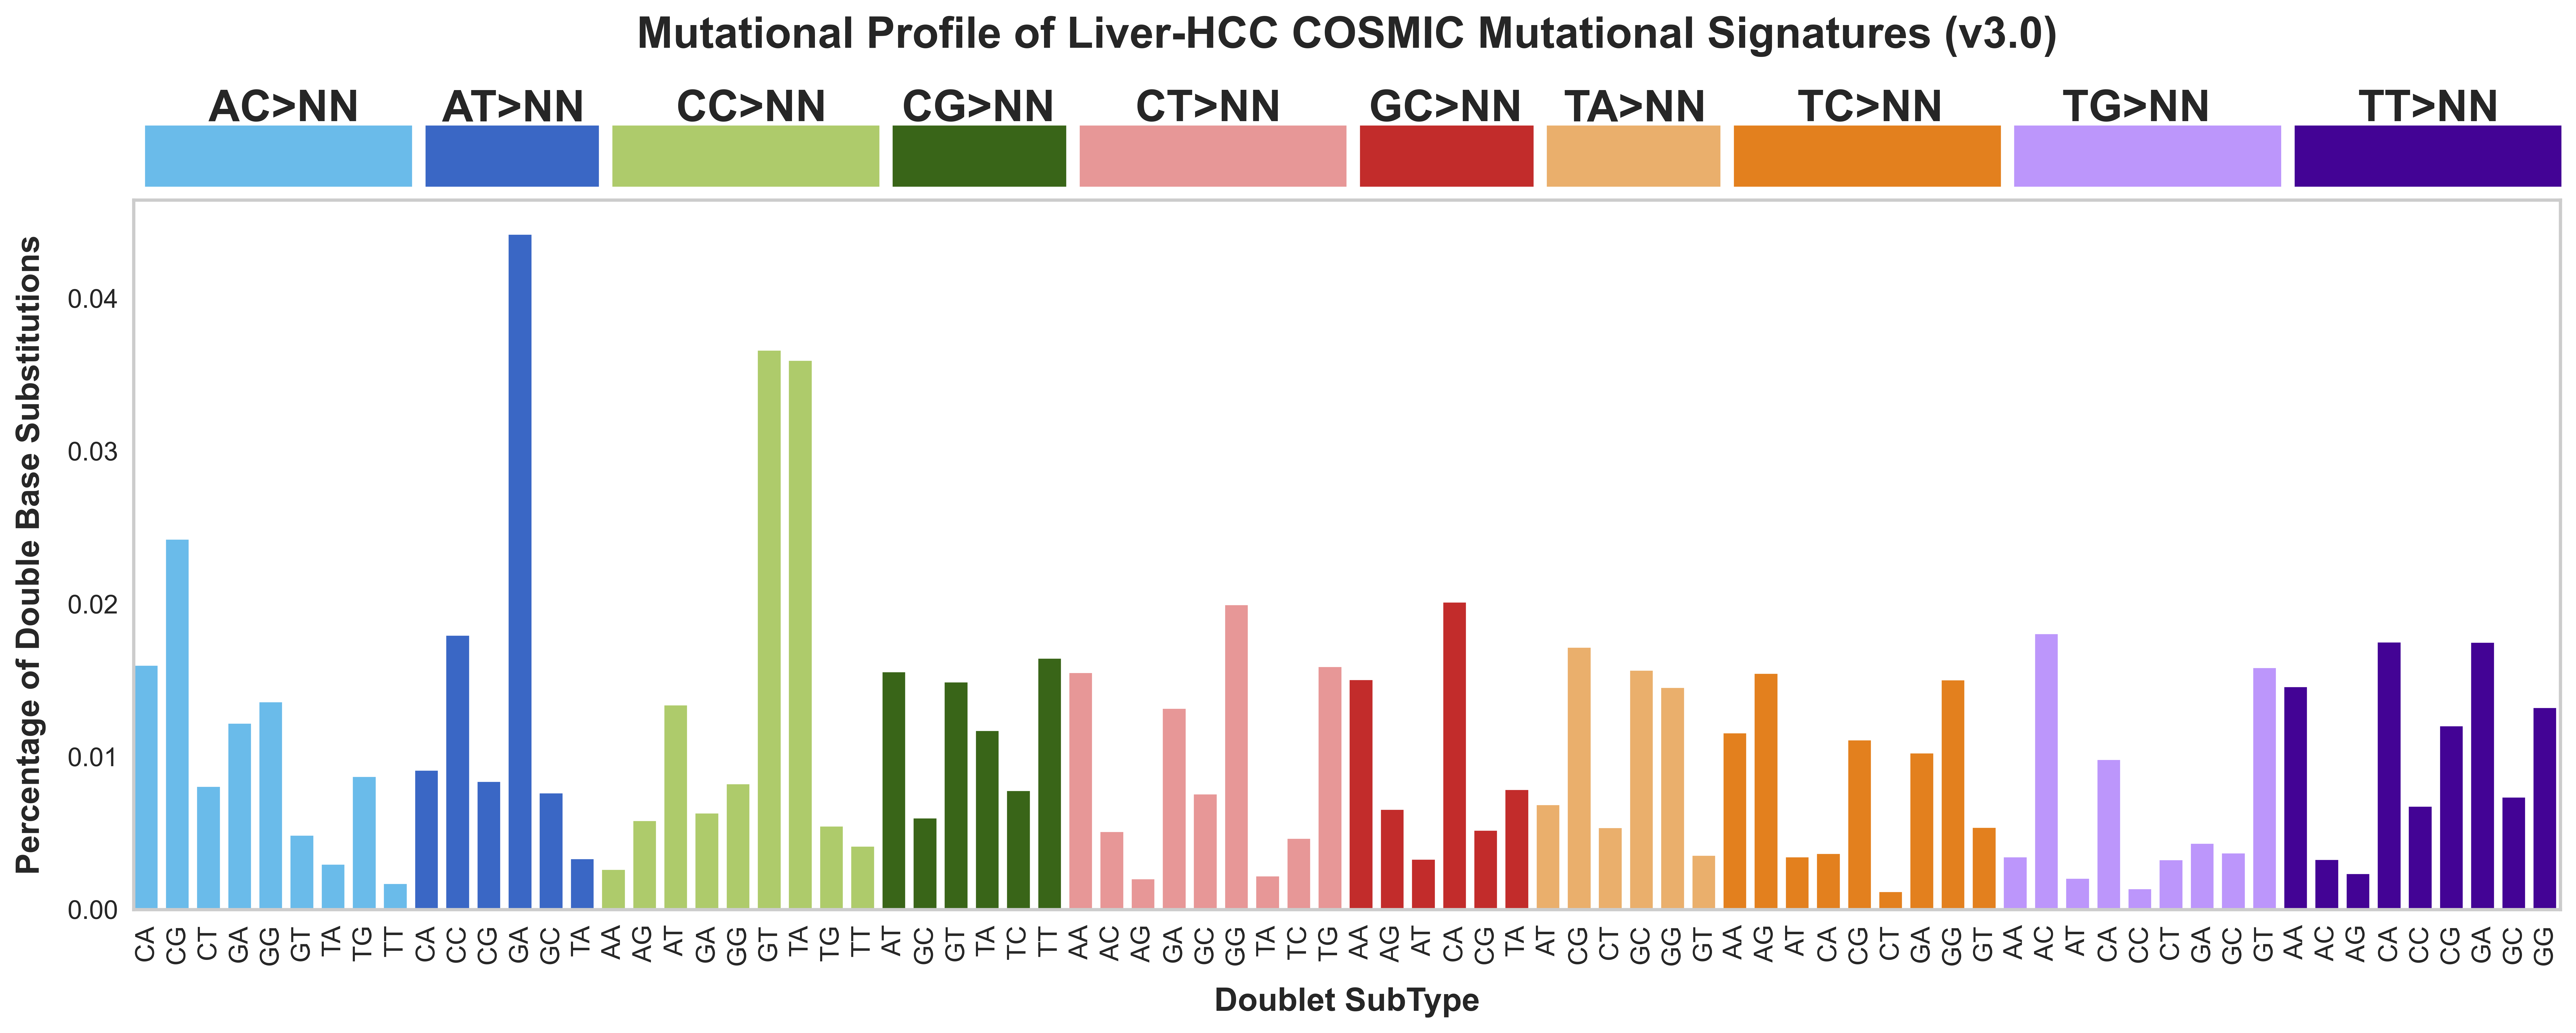

In [440]:
dbs_sig_plot(cancer_type="Liver-HCC", signature=simulated_liver_mean)

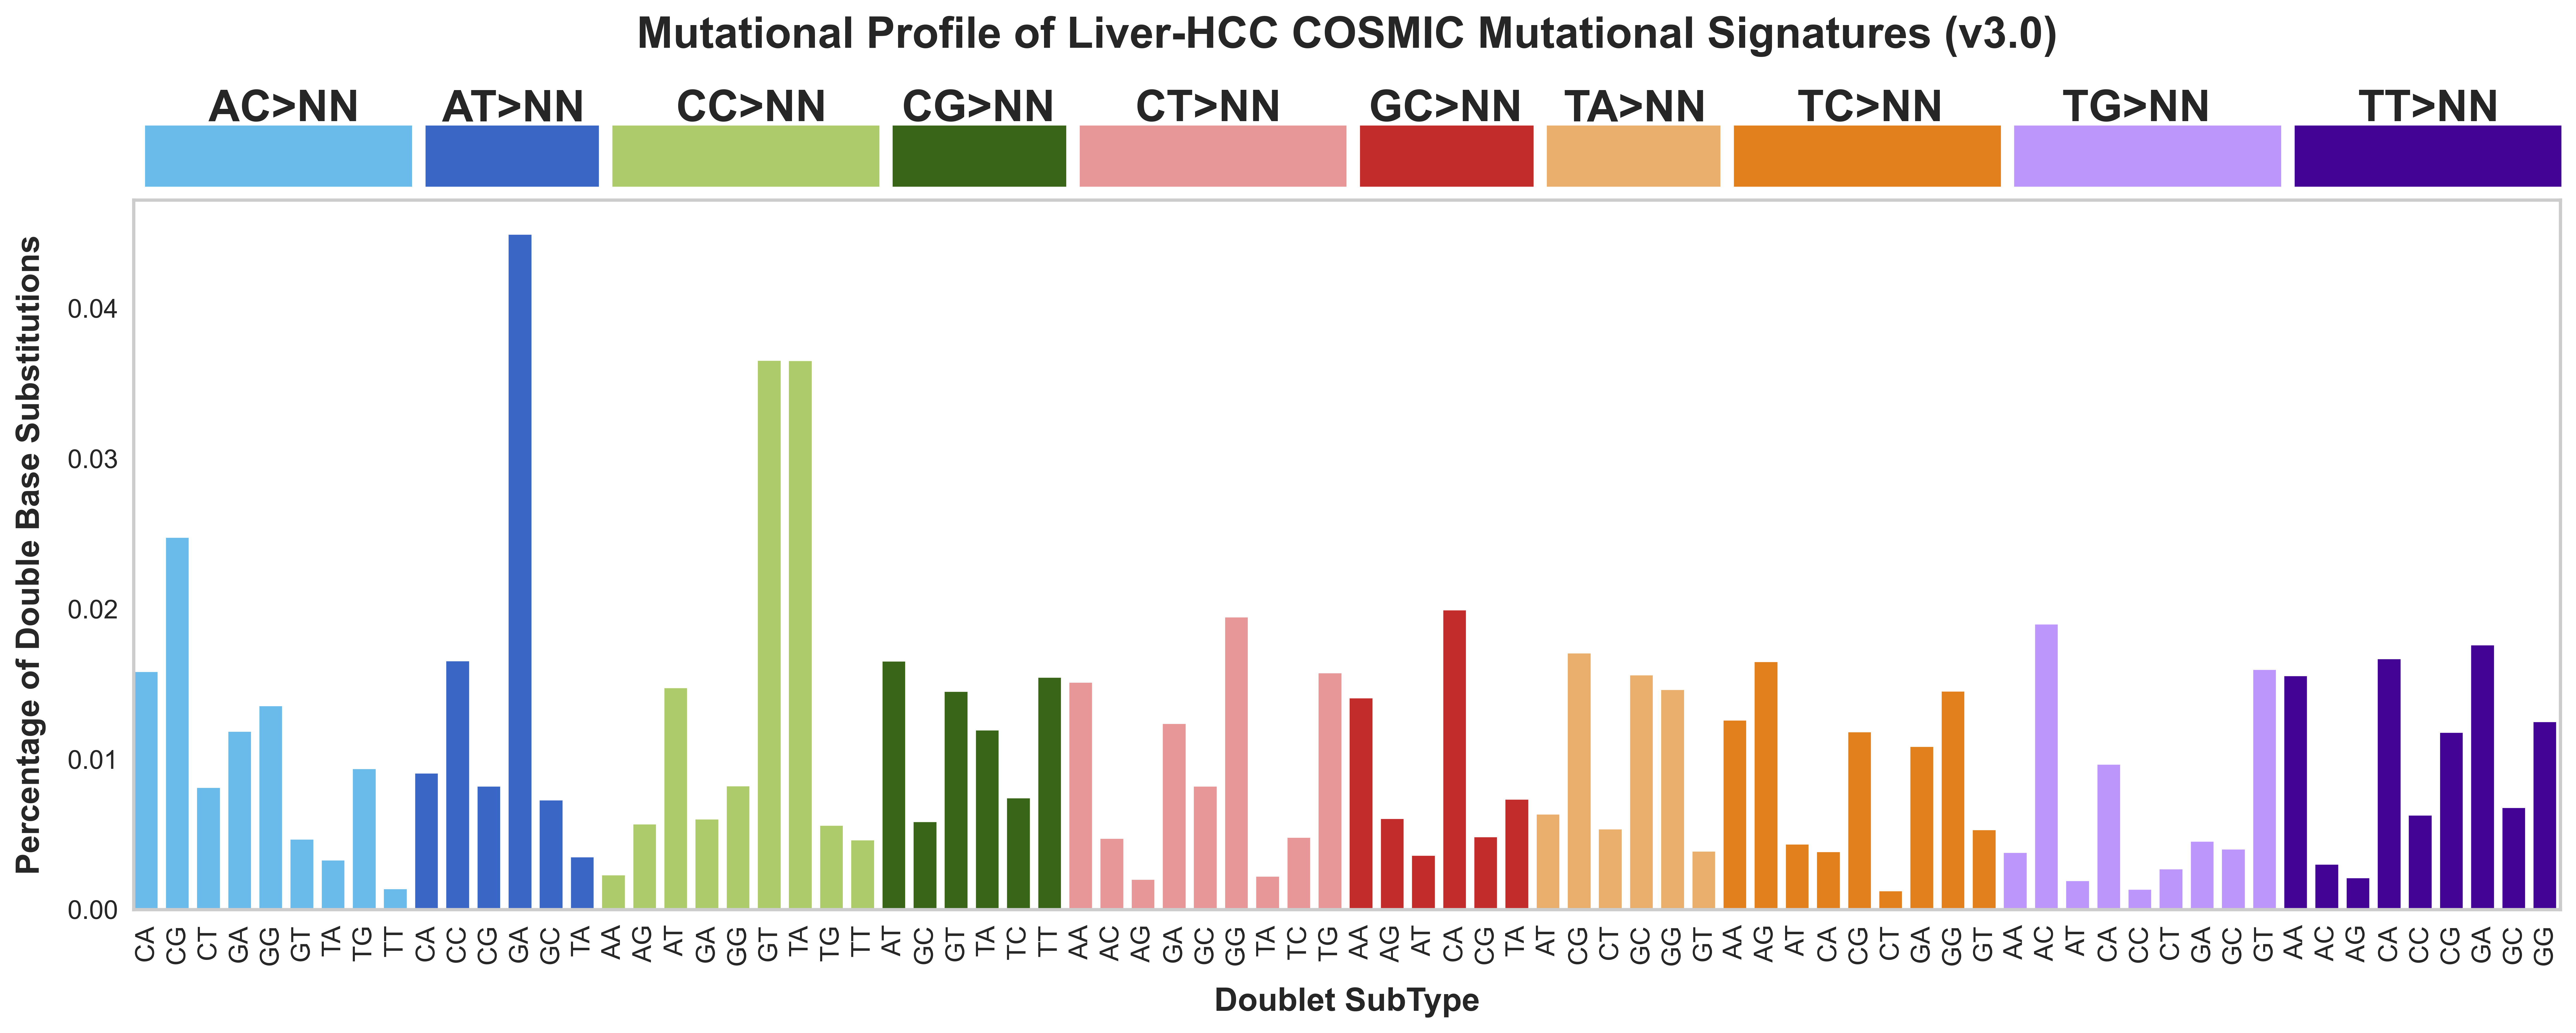

In [441]:
dbs_sig_plot(cancer_type="Liver-HCC", signature=real_liver_mean)

In [342]:
normalized_simulated_liver = simulated_liver.div(simulated_liver.sum(axis=0), axis=1)

In [343]:
normalized_real_liver = real_liver.div(real_liver.sum(axis=0), axis=1)

In [349]:
import seaborn as sns

In [404]:
def sbs_boxplot(data):
    color_list = [(0.416, 0.733, 0.918), (0,0,0), (0.765, 0.172, 0.157), (0.785, 0.785, 0.785), (0.678, 0.808, 0.412), (0.878, 0.773, 0.769)]
    sns.set_style("white")
    fig, ax= plt.subplots(figsize=(20, 6))
    sns.boxplot(x="variable", y="value", data=data, palette=[item for item in color_list for i in range(16)],
               flierprops=dict(marker='o', markerfacecolor='black', markersize=4,markeredgecolor='none'))
    ax.set_xticklabels(
      pd.read_csv(sbs_prop_file_path)['SubType'], 
      rotation=90, 
      fontweight='light',
      fontsize='medium')

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 15, y_limit/20, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((16, y_limit + y_limit/50), 15, y_limit/20, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((32, y_limit + y_limit/50), 15, y_limit/20, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((48, y_limit + y_limit/50), 15, y_limit/20, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((64, y_limit + y_limit/50), 15, y_limit/20, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((80, y_limit + y_limit/50), 15, y_limit/20, color = color_list[5], clip_on=False) 

    plt.text(6, y_limit + y_limit/9, "C>A", fontsize=20, weight="bold")
    plt.text(22, y_limit + y_limit/9, "C>G", fontsize=20, weight="bold")
    plt.text(38, y_limit + y_limit/9, "C>T", fontsize=20, weight="bold")
    plt.text(54, y_limit + y_limit/9, "T>A", fontsize=20, weight="bold")
    plt.text(70, y_limit + y_limit/9, "T>C", fontsize=20, weight="bold")
    plt.text(86, y_limit + y_limit/9, "T>G", fontsize=20, weight="bold")

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)

    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    plt.rcParams["figure.dpi"] = 600
    ax.set_ylim(0,)
    ax.set_xlabel('Trinucleotide SubType', fontsize=15, weight="bold")
    ax.set_ylabel('Proportion of Single Base Substitutions', fontsize=15, weight="bold")
    #ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=True)
    plt.show()

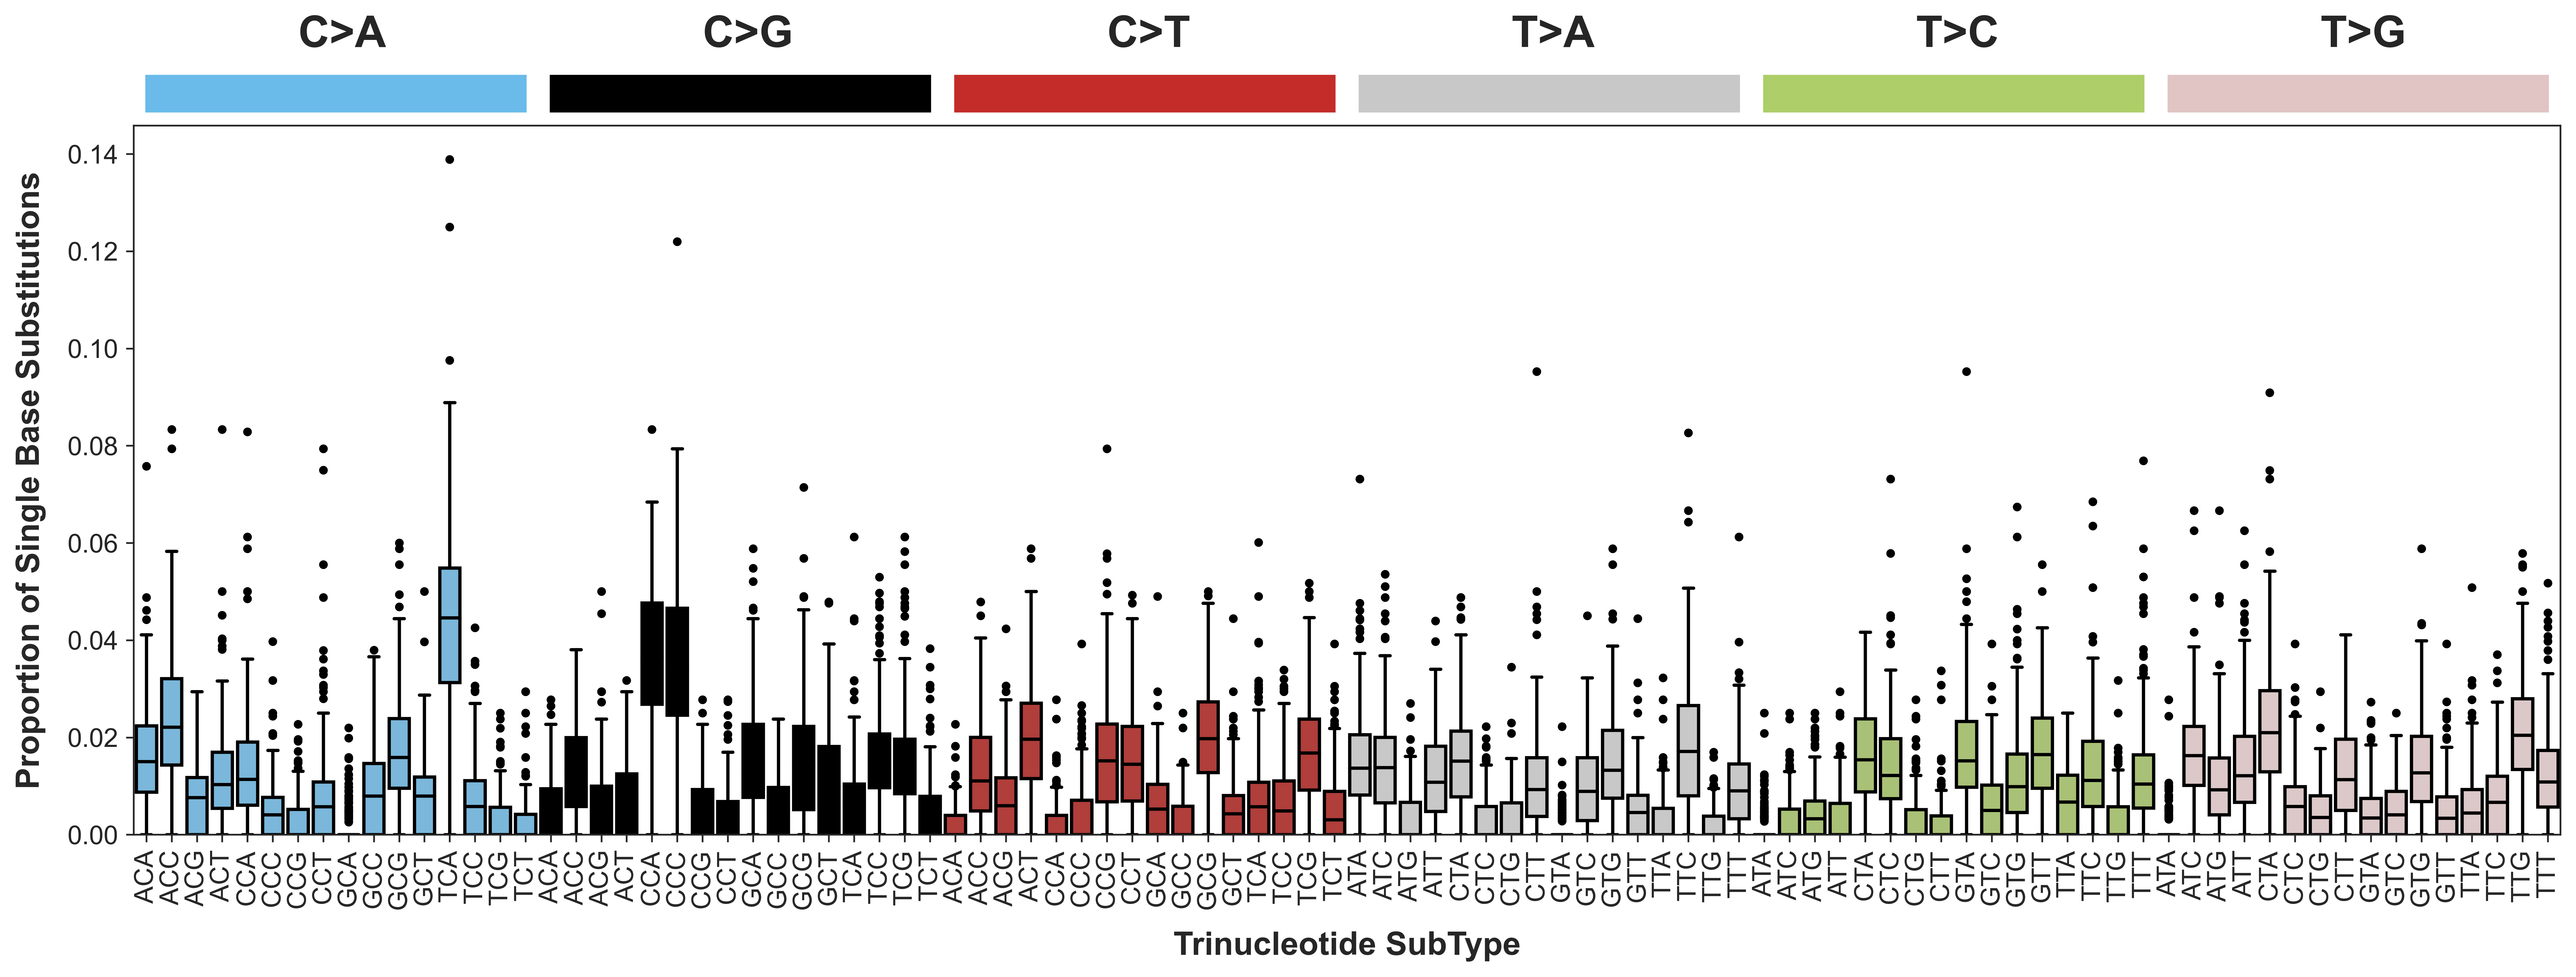

In [405]:
sbs_boxplot(normalized_simulated_liver.T.melt())

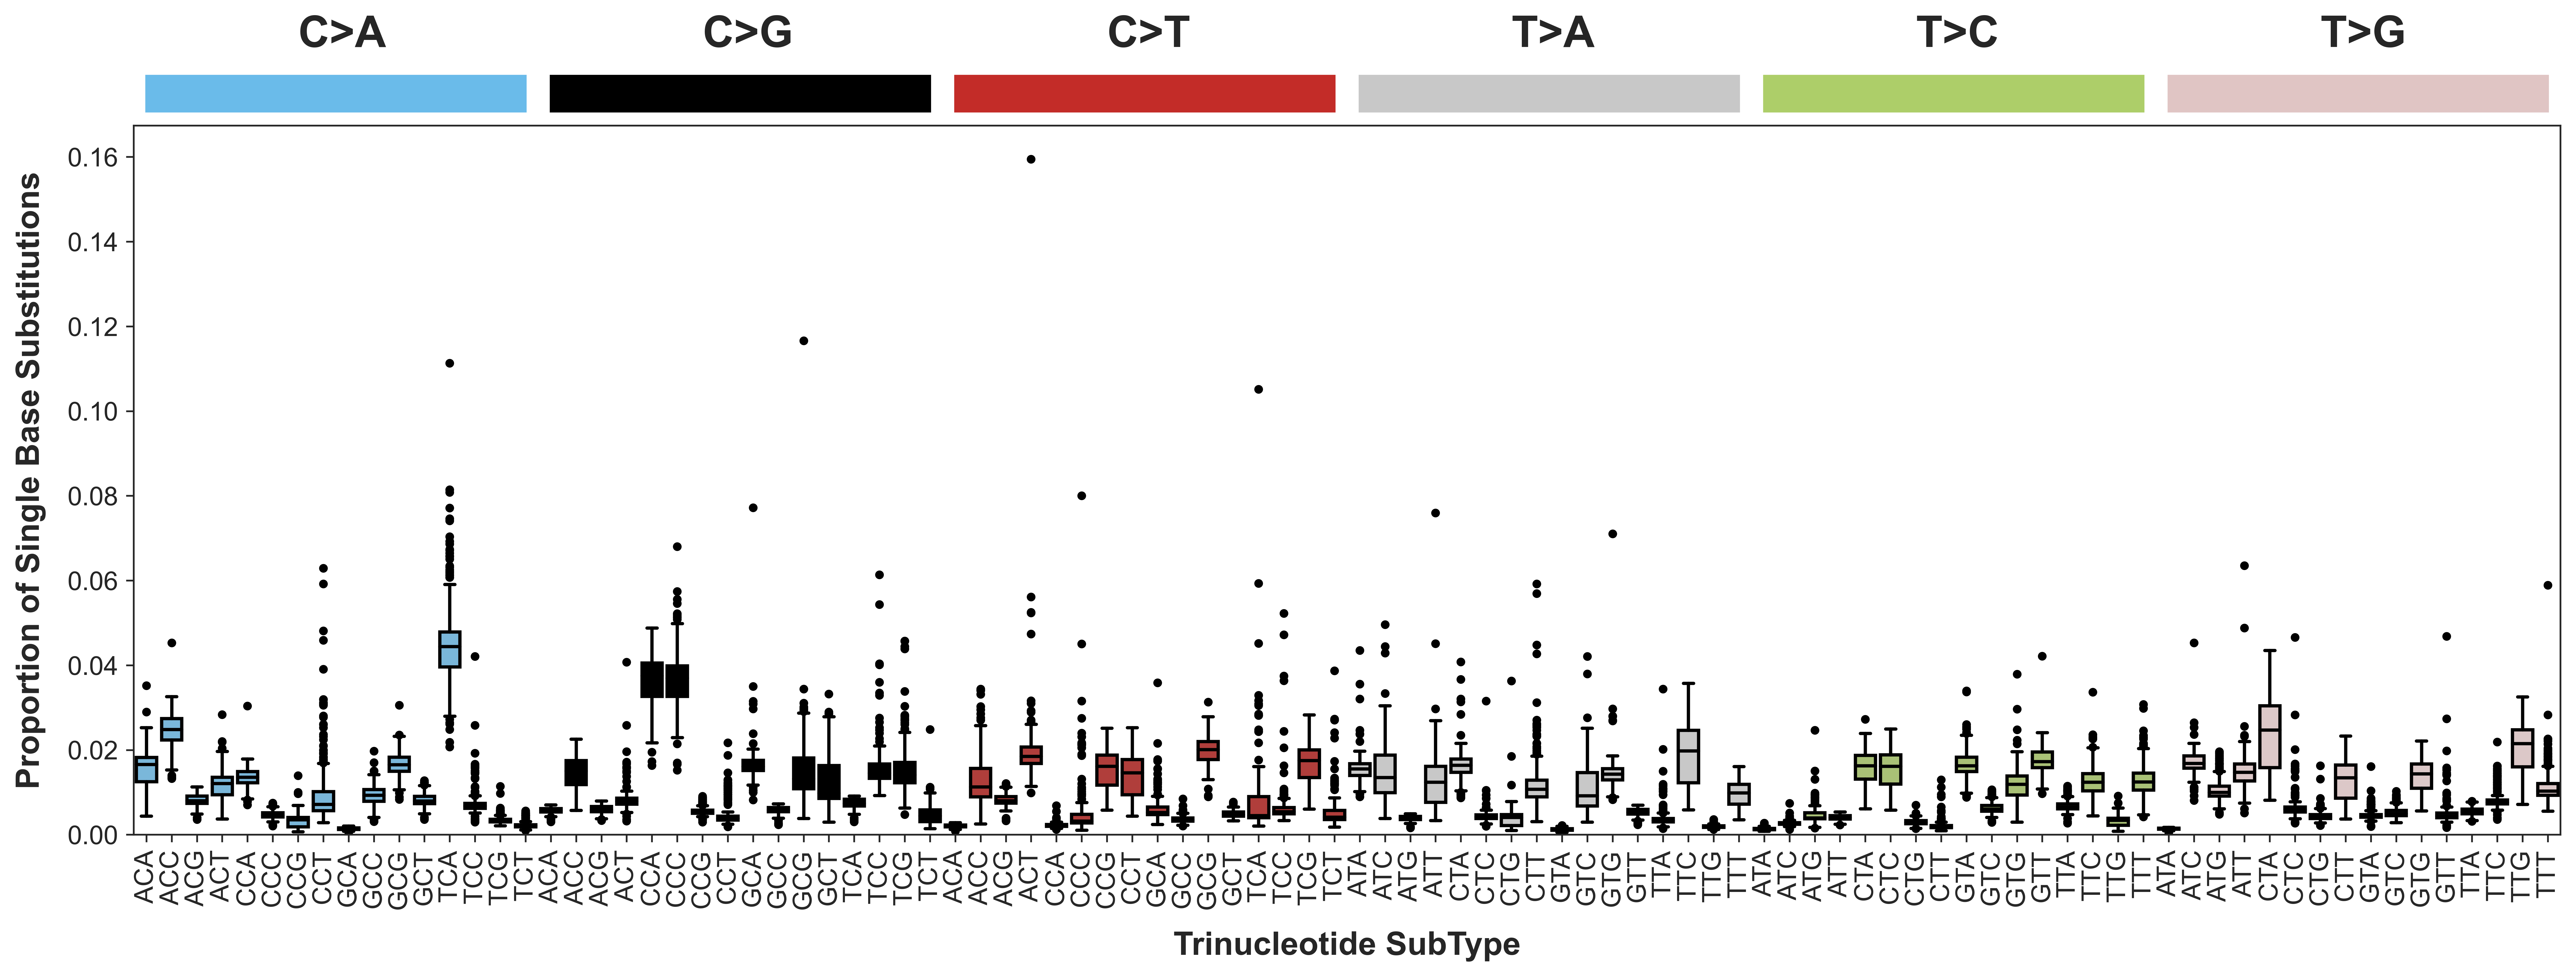

In [406]:
sbs_boxplot(normalized_real_liver.T.melt())

In [442]:
def dbs_boxplot(data):
    color_list = [(0.416, 0.733, 0.918), 
                  (0.227, 0.404, 0.773), 
                  (0.682, 0.796, 0.420), 
                  (0.224, 0.396, 0.0941), 
                  (0.906, 0.592, 0.592), 
                  (0.761, 0.173, 0.170),
                  (0.918, 0.686, 0.424),
                  (0.89, 0.502, 0.118),
                  (0.737, 0.588, 0.984),
                  (0.263, 0.0118, 0.584)]
    sns.set_style("white")
    fig, ax= plt.subplots(figsize=(20, 6))
    sns.boxplot(x="variable", y="value", data=data, palette=[item for item in color_list for i in range(16)],
               flierprops=dict(marker='o', markerfacecolor='black', markersize=4,markeredgecolor='none'))
    ax.set_xticklabels(
      pd.read_csv(sbs_prop_file_path)['SubType'], 
      rotation=90, 
      fontweight='light',
      fontsize='medium')

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((9, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((15, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((24, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((30, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((39, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[5], clip_on=False) 
    rect7 = patches.Rectangle((45, y_limit + y_limit/50), 5.5, y_limit/12, color = color_list[6], clip_on=False) 
    rect8 = patches.Rectangle((51, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[7], clip_on=False) 
    rect9 = patches.Rectangle((60, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[8], clip_on=False) 
    rect10 = patches.Rectangle((69, y_limit + y_limit/50), 8.5, y_limit/12, color = color_list[9], clip_on=False) 

    plt.text(2, y_limit + y_limit/9, "AC>NN", fontsize=20, weight="bold")
    plt.text(9.5, y_limit + y_limit/9, "AT>NN", fontsize=20, weight="bold")
    plt.text(17, y_limit + y_limit/9, "CC>NN", fontsize=20, weight="bold")
    plt.text(24.25, y_limit + y_limit/9, "CG>NN", fontsize=20, weight="bold")
    plt.text(31.75, y_limit + y_limit/9, "CT>NN", fontsize=20, weight="bold")
    plt.text(39.25, y_limit + y_limit/9, "GC>NN", fontsize=20, weight="bold")
    plt.text(45.5, y_limit + y_limit/9, "TA>NN", fontsize=20, weight="bold")
    plt.text(53, y_limit + y_limit/9, "TC>NN", fontsize=20, weight="bold")
    plt.text(61.5, y_limit + y_limit/9, "TG>NN", fontsize=20, weight="bold")
    plt.text(71, y_limit + y_limit/9, "TT>NN", fontsize=20, weight="bold")        

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)
    ax.add_patch(rect7)
    ax.add_patch(rect8)
    ax.add_patch(rect9)
    ax.add_patch(rect10)

    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10
    plt.rcParams["figure.dpi"] = 600
    ax.set_ylim(0,)
    ax.set_xlabel('Dinucleotide SubType', fontsize=15, weight="bold")
    ax.set_ylabel('Proportion of Double Base Substitutions', fontsize=15, weight="bold")
    #ax.set_xticks(range(len(ax.get_xticklabels())))
    ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=True)
    plt.show()

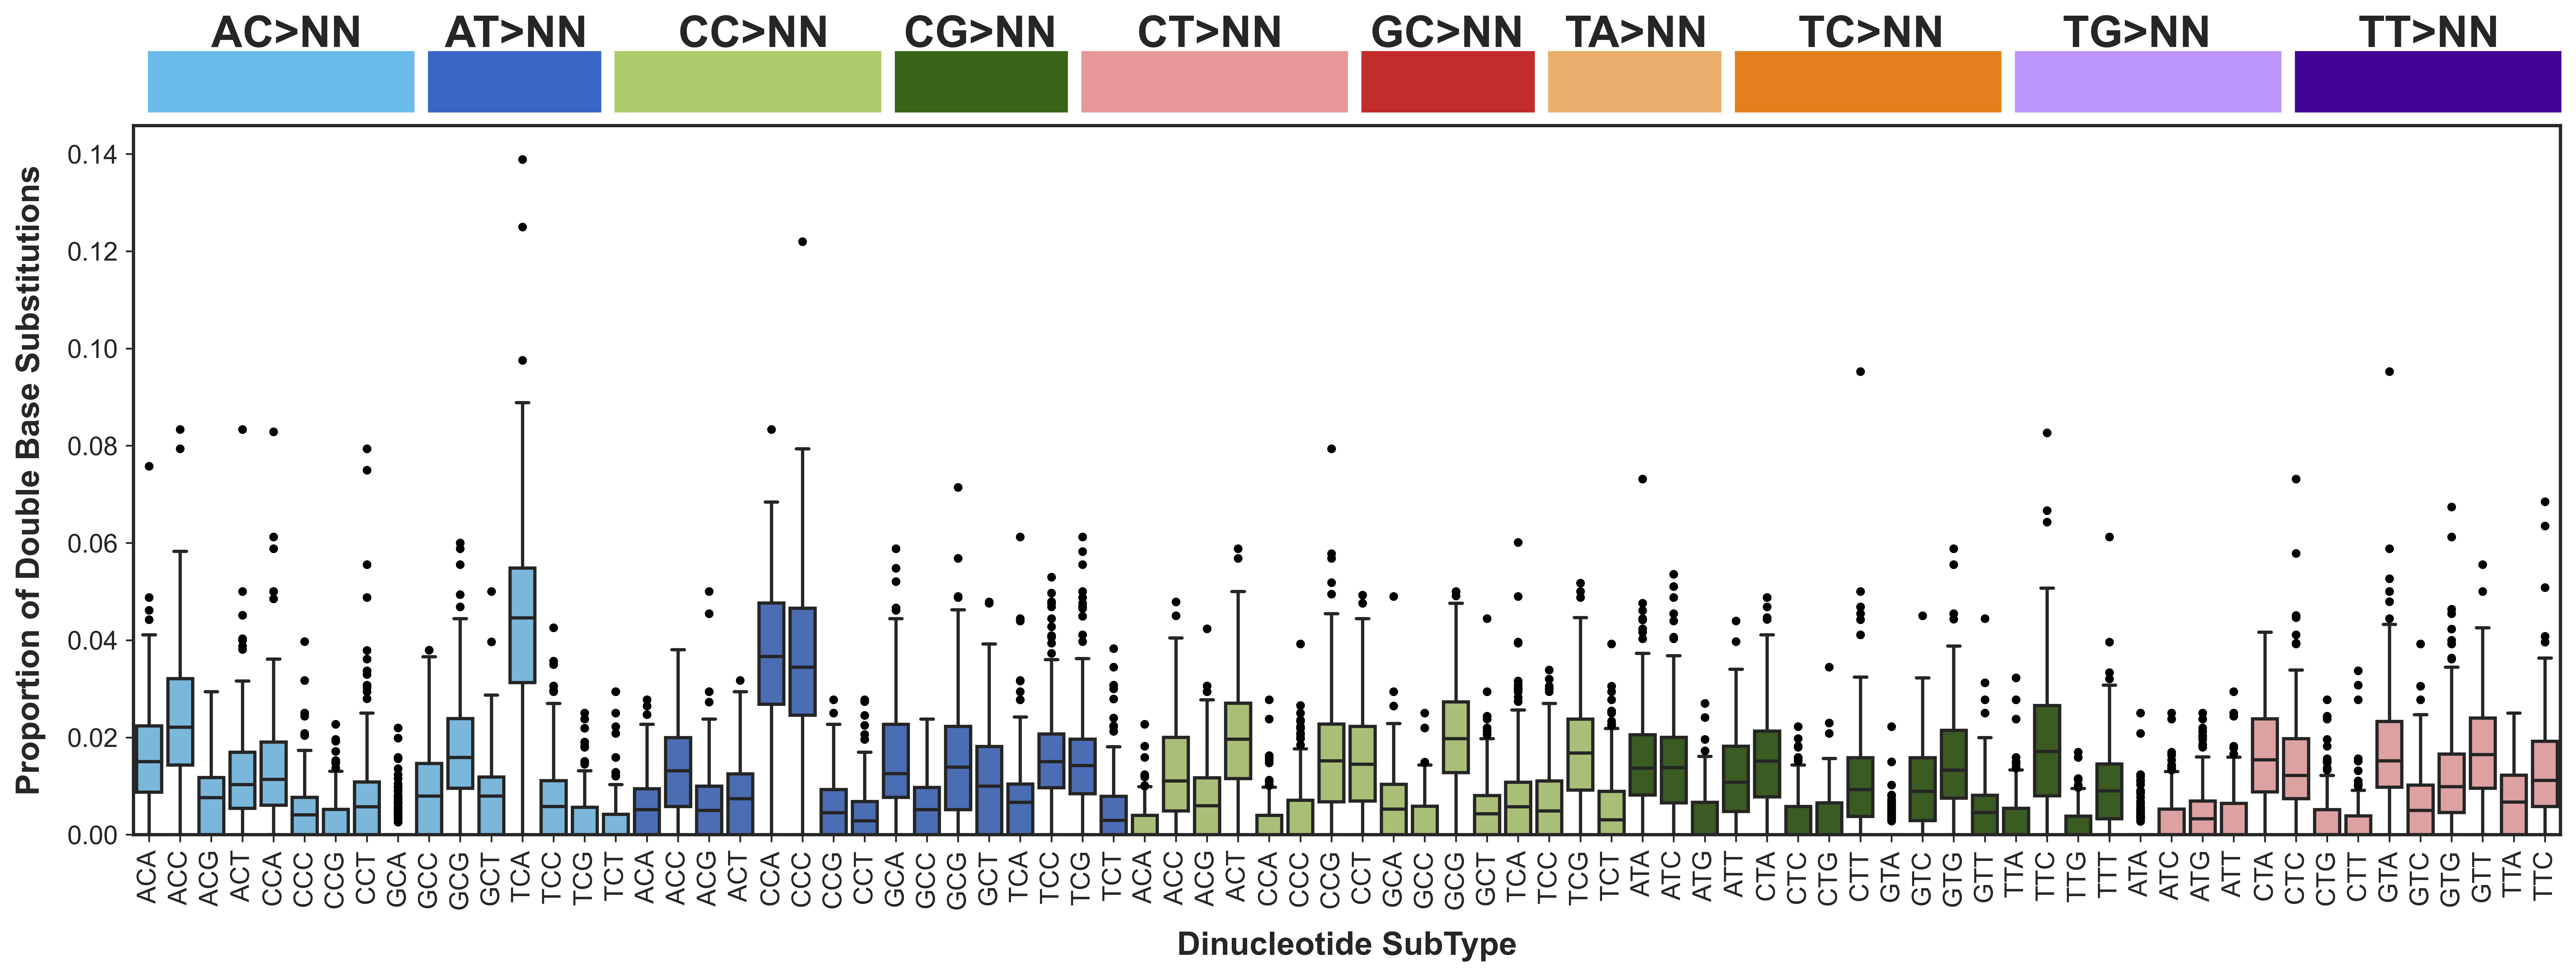

In [447]:
dbs_boxplot(data=normalized_simulated_liver.iloc[:78,:].T.melt())

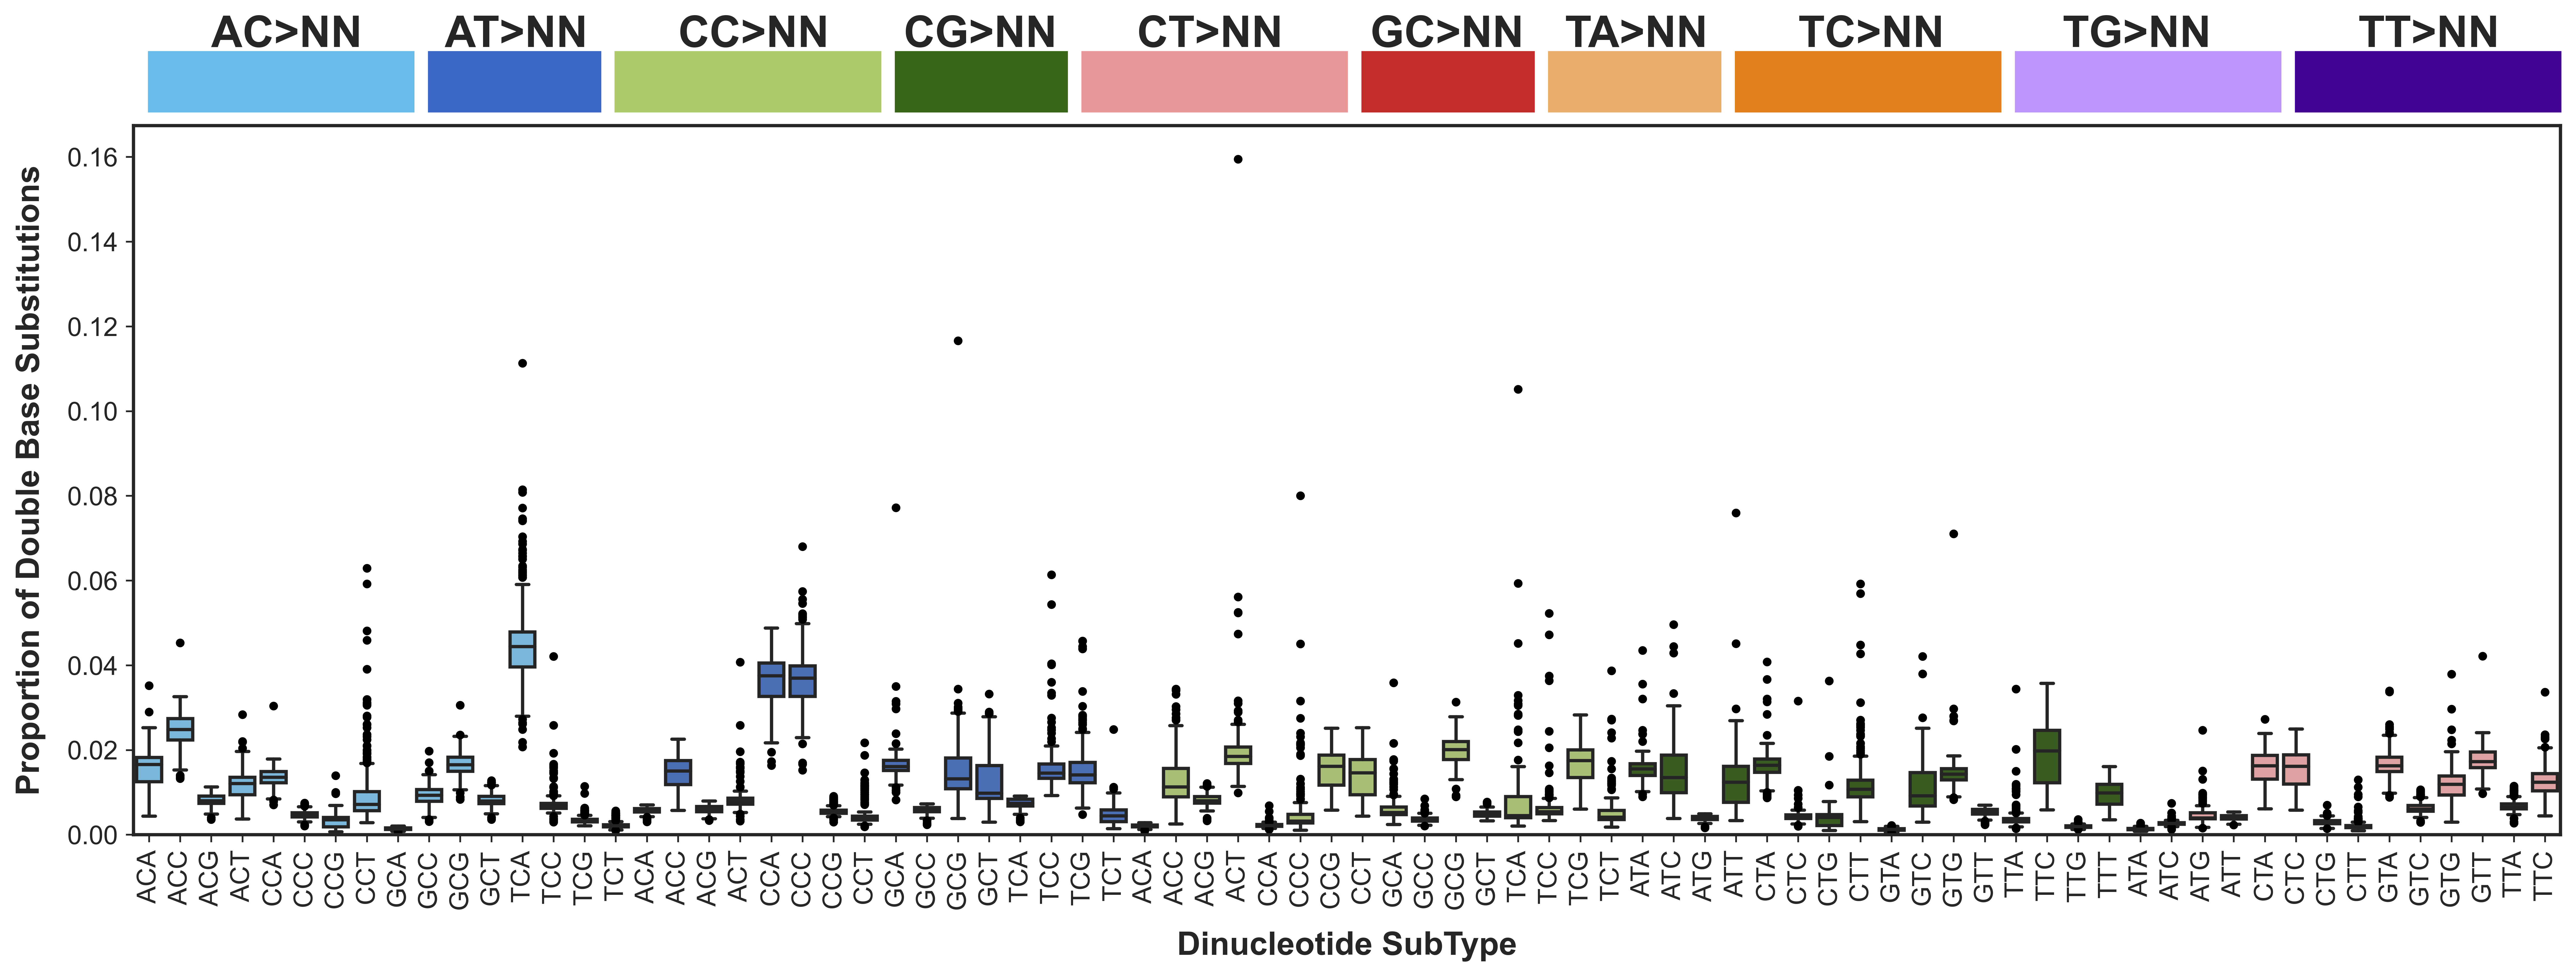

In [448]:
dbs_boxplot(data=normalized_real_liver.iloc[:78,:].T.melt())

# Barplot of the Mean of SBS-96 Mutation Proportions for Simulated Data

<BarContainer object of 96 artists>

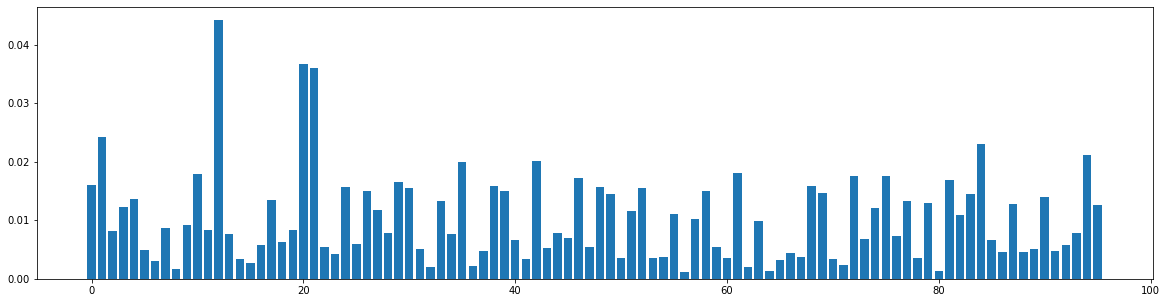

In [264]:
f, ax = plt.subplots(figsize=(20,5))
plt.bar(range(96), simulated_liver_mean.tolist())

# Individual Welch's T-Test for each mutation type in the SBS-96 classication scheme

In [265]:
normalized_real_liver = real_liver.div(real_liver.sum(axis=0), axis=1)
normalized_simulated_liver = simulated_liver.div(simulated_liver.sum(axis=0), axis=1)

In [183]:
normalized_real_liver.to_csv("Liver-HCC_Real.csv")

In [184]:
normalized_simulated_liver.to_csv("Liver-HCC_Simulated.csv")

In [284]:
p_value = []
for mut_type in range(96):
    p_value.append(stats.ttest_ind(normalized_real_liver.iloc[mut_type,:].values, normalized_simulated_liver.iloc[mut_type,:].values, equal_var = False)[1])

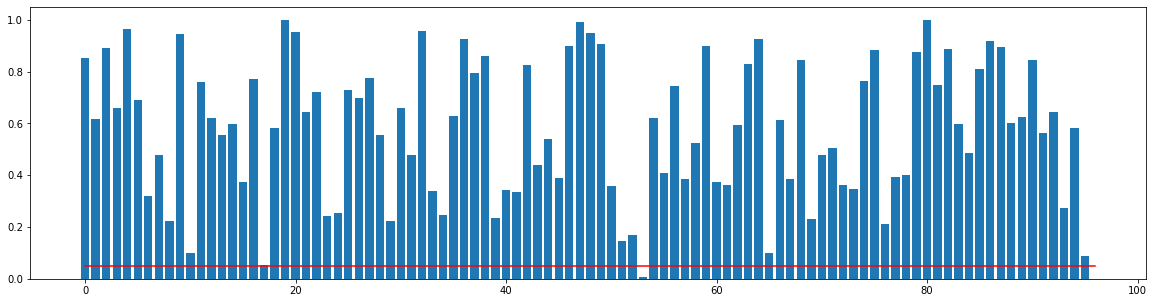

In [285]:
f, ax = plt.subplots(figsize=(20,5))
plt.bar(range(96), p_value)
plt.plot([0,96], [0.05,0.05], c="red")

In [286]:
len([1 for i in p_value if i > 0.05])

95

# Hotellier T-squared Multivariate T Test

In [145]:
import hotelling

In [273]:
res = hotelling_t2(normalized_real_liver.T, normalized_simulated_liver.T)

In [277]:
res[2]

0.0002440408764237066

# Differences between Real vs Simulated Data

1. Approximation of Distribution is less sensitive to minute differences when using a shorter sequence vs whole genome

2. Difference in k-mer proportions when using a shorter sequence vs whole genome

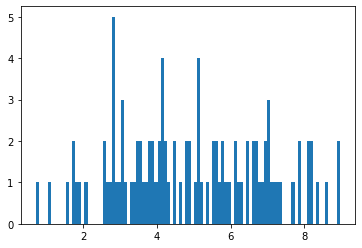

In [278]:
mu = 5.0
sigma = 2.0
values = np.random.normal(mu, sigma, 100)
plt.hist(values, bins=100)
plt.show()

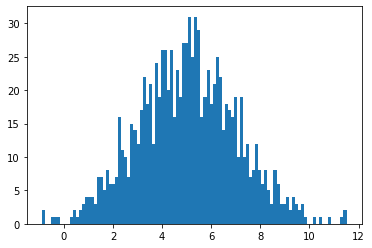

In [279]:
mu = 5.0
sigma = 2.0
values = np.random.normal(mu, sigma, 1000)
plt.hist(values, bins=100)
plt.show()

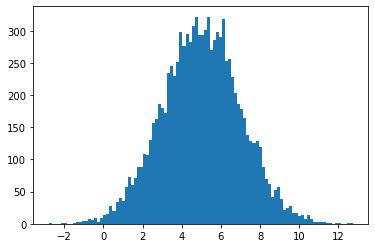

In [280]:
mu = 5.0
sigma = 2.0
values = np.random.normal(mu, sigma, 10000)
plt.hist(values, bins=100)
plt.show()

# DBS-78 Real vs. Simulated Comparison

In [59]:
k2mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/Homo_sapiens.GRCh38.dna.chromosome.22.fasta", 
                                      slice_start=0, 
                                      slice_end=50818467, 
                                      kmer_length = 2, 
                                      count=True)

In [76]:


outlier = outlier_detection(cancer_type="Liver-HCC", num_data=dbs_num_data, std_outlier=10)

test = dbs_num_data[dbs_num_data["Cancer Types"] == "Liver-HCC"]
test[~test['Sample Names'].isin(outlier)]

filtered_df = test[~test['Sample Names'].isin(outlier)].reset_index(drop=True).iloc[:, 3:]

real_liver = pd.DataFrame(index=range(78), columns=range(len(filtered_df)), data=0)

for sequence in range(len(filtered_df)):
    
    for signature in filtered_df.columns:
        
        signature_burden = filtered_df.loc[sequence, signature]
        
        dbs_78 = signature_burden * dbs_prop_data.loc[:, signature]
        
        real_liver[sequence] += dbs_78

In [77]:
file_list = glob.glob('Frequency_Table/*dbs_freq_table.csv')
file_list = sorted(file_list)[519:]
len(file_list)

200

In [78]:
simulated_liver = pd.DataFrame(index=range(78), columns=range(len(file_list)), data=0)
for file in file_list:
    simulated_liver[file_list.index(file)] = pd.read_csv(file).iloc[:,1]

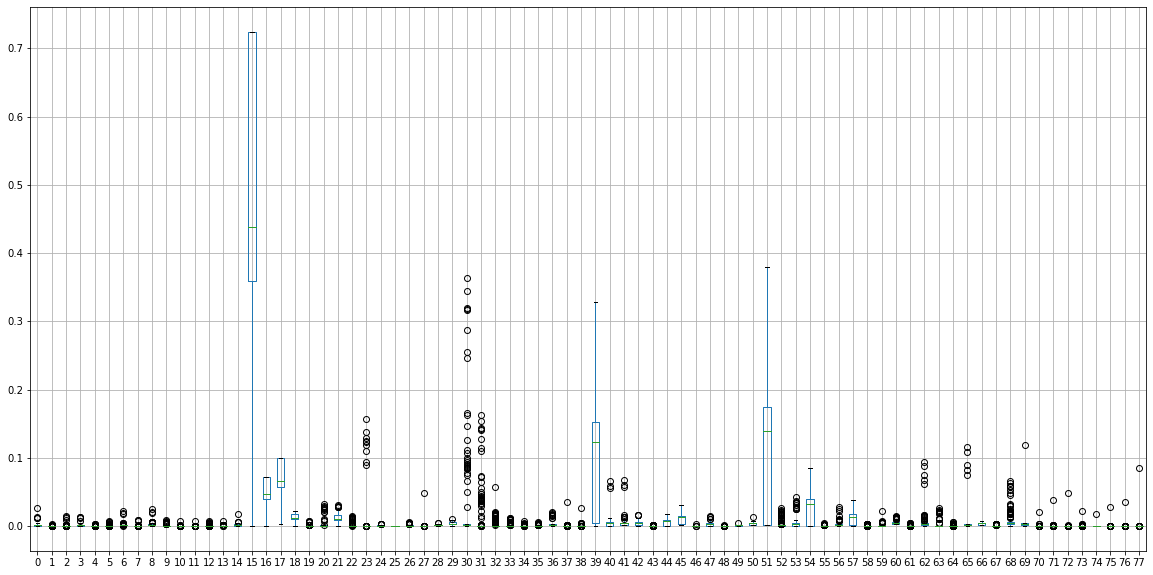

In [79]:
real_liver.div(real_liver.sum(axis=0), axis=1).T.boxplot(figsize=(20,10))

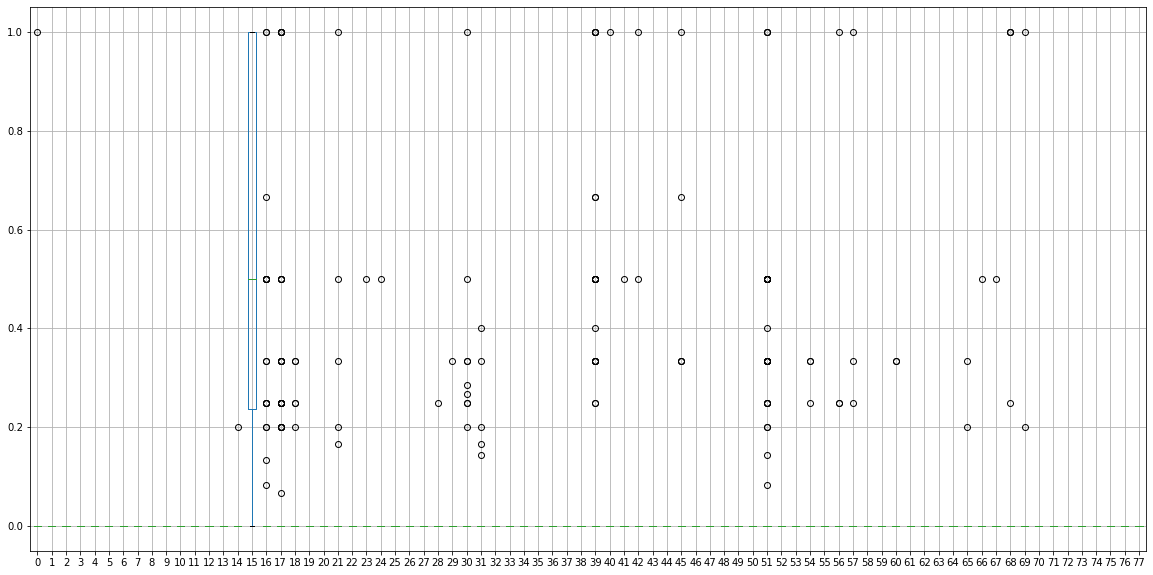

In [80]:
simulated_liver.div(simulated_liver.sum(axis=0), axis=1).T.boxplot(figsize=(20,10))

In [81]:
real_liver_mean = real_liver.div(real_liver.sum(axis=0), axis=1).mean(axis=1)

In [82]:
simulated_liver_mean = simulated_liver.div(simulated_liver.sum(axis=0), axis=1).mean(axis=1)

In [83]:
cosine_similarity([real_liver_mean.tolist(), simulated_liver_mean.tolist()])

array([[1.        , 0.99174525],
       [0.99174525, 1.        ]])

<BarContainer object of 78 artists>

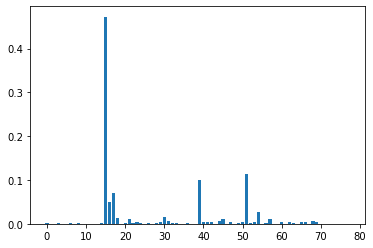

In [87]:
plt.bar(range(78), real_liver_mean.tolist())

<BarContainer object of 78 artists>

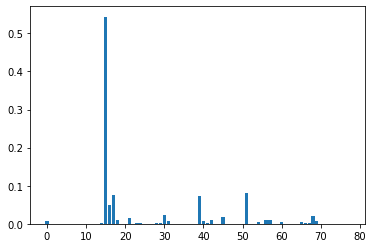

In [88]:
plt.bar(range(78), simulated_liver_mean.tolist())

# Indel-24 Real vs. Simulated Comparison

In [92]:
k1mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/Homo_sapiens.GRCh38.dna.chromosome.22.fasta", 
                                      slice_start=0, 
                                      slice_end=50818467, 
                                      kmer_length = 1, 
                                      count=True)

In [89]:
k4mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/Homo_sapiens.GRCh38.dna.chromosome.22.fasta", 
                                      slice_start=0, 
                                      slice_end=50818467, 
                                      kmer_length = 4, 
                                      count=True)

In [90]:
k5mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/Homo_sapiens.GRCh38.dna.chromosome.22.fasta", 
                                      slice_start=0, 
                                      slice_end=50818467, 
                                      kmer_length = 5, 
                                      count=True)

In [91]:
k6mer_count_map = sequence_index_dict(input_file_path="/Users/davidchen/Documents/GitHub/SomaticSiMu/Reference_genome/Homo_sapiens.GRCh38.dna.chromosome.22.fasta", 
                                      slice_start=0, 
                                      slice_end=50818467, 
                                      kmer_length = 6, 
                                      count=True)

In [94]:
outlier = outlier_detection(cancer_type="Liver-HCC", num_data=id_num_data, std_outlier=10)

test = id_num_data[id_num_data["Cancer Types"] == "Liver-HCC"]
test[~test['Sample Names'].isin(outlier)]

filtered_df = test[~test['Sample Names'].isin(outlier)].reset_index(drop=True).iloc[:, 3:]

real_liver = pd.DataFrame(index=range(24), columns=range(len(filtered_df)), data=0)

for sequence in range(len(filtered_df)):
    
    for signature in filtered_df.columns:
        
        signature_burden = filtered_df.loc[sequence, signature]
        
        indel_24 = signature_burden * id_prop_data.loc[:, signature]
        
        real_liver[sequence] += indel_24

In [95]:
real_liver

0           1           2           3           4          5    \
0    60.693493   29.221423   51.162809   42.469636   24.684357  10.766487   
1    90.865460   43.052845   76.757350   67.107124   36.195049  11.844042   
2    74.091353   34.919765   62.846740   56.011902   29.887640   8.974601   
3    29.412561   14.261585   24.952415   21.630361   12.589029   3.714971   
4    17.557752    8.415880   14.766096   13.587620    6.646361   2.177793   
5     9.872807    5.483532    8.229412    7.875180    4.164725   1.162432   
6    51.435184   26.672802   45.698540   29.868139   33.198543   8.955535   
7    38.997278   20.320887   35.658613   21.776474   29.315576   7.144602   
8    42.488324   22.418613   38.797902   24.257011   31.804263   8.180490   
9    36.637083   19.801035   33.114006   21.820560   26.181562   7.262284   
10   22.646346   13.601947   20.335274   15.120192   16.037429   4.725629   
11   14.286706   35.057450   12.765703   31.576458    9.547127   2.222508   
12    1.470092    0.724244    1.223690    0.854213    0.604255   0.159320   
13    1.379762    0.697232    1.173406    0.793851    0.673716   0.168474   
14    1.895002    0.960031    1.666012    1.111921    1.133022   0.276691   
15    2.644504    1.341063    2.204676    2.028691    1.095862   0.310196   
16    3.114843    1.737089    2.551755    2.449498    1.291455   0.349927   
17    7.204554    6.160354    5.228852    5.592259    4.890343   0.778515   
18   10.137020    5.158862    8.564523    7.089459    4.719828   1.390097   
19   21.009605   10.069658   17.955963   15.067810    9.363500   2.752904   
20   24.183718   11.864273   21.110730   16.695149   12.871456   3.401357   
21   15.963709    8.263410   13.772804   11.039861    8.772037   2.220620   
22    8.910512    6.196986    7.226188    6.015756    6.359894   1.236171   
23  169.947635  170.803031  112.305325  122.264671  144.180539  17.582440   

          6          7           8           9    ...        314         315  \
0   33.780636  18.444132   17.813521   25.028634  ...   9.255368   91.643955   
1   53.686050  13.867025   12.884675   36.481380  ...  14.775040   85.418536   
2   44.681666   8.492458    8.105978   29.573339  ...  12.627451   59.116044   
3   17.016909   3.854301    5.039801   12.351483  ...   5.068745   25.168871   
4   10.863706   2.338269    1.390563    7.083349  ...   2.943310   15.461699   
5    5.897189   1.147596    1.592522    4.921099  ...   1.898304    8.218130   
6   20.472365  11.599661   32.609230   25.761696  ...  10.231729   58.325663   
7   13.865452   7.897558   27.834171   20.419455  ...   8.968259   39.878167   
8   15.398362   9.739535   30.958026   22.528443  ...   9.908781   48.073069   
9   13.996843   9.520597   26.611568   19.710623  ...   8.412025   46.270836   
10   9.182171   6.565839   15.866073   13.658618  ...   5.735776   31.784423   
11   5.378790   2.506391   11.123688   37.307705  ...  11.802659   13.384775   
12   0.683281   0.229076    0.997027    0.629750  ...   0.166739    1.315120   
13   0.601380   3.323547   13.735245    0.630396  ...   0.192934   16.752163   
14   0.793394   2.088513    8.429175    0.906510  ...   0.347843   10.602591   
15   1.600696   0.988195    3.168655    1.174215  ...   0.470030    5.616582   
16   1.878037   0.573293    1.400300    1.564760  ...   0.575286    3.722526   
17   3.734594   1.077290    4.782623    6.563663  ...   1.958544    8.696909   
18   5.467985   1.725672    3.712744    4.623626  ...   1.758005   10.182102   
19  11.796498   8.890913   28.934258    8.756327  ...   3.626067   48.192382   
20  12.495894   6.325487   20.187661   10.787339  ...   4.716061   35.561741   
21   8.177012   4.222072   14.019599    7.693845  ...   3.212003   24.011553   
22   3.999456   2.324984    9.800980    6.477955  ...   2.248855   14.064004   
23  77.738811  27.521732  165.104200  192.040172  ...  52.497821  235.869526   

          316         317         318        319         320         321  \
0    8.5

In [103]:
del_file_list = glob.glob('Frequency_Table/*del_freq_table.csv')
del_file_list = sorted(del_file_list)[519:]
len(del_file_list)

200

In [104]:
ins_file_list = glob.glob('Frequency_Table/*ins_freq_table.csv')
ins_file_list = sorted(ins_file_list)[519:]
len(ins_file_list)

200

In [107]:
simulated_liver = pd.DataFrame(index=range(24), columns=range(len(del_file_list)), data=0)
for i in range(200):
    
    df1 = pd.read_csv(del_file_list[i]).iloc[:,2].tolist()
    df2 = pd.read_csv(ins_file_list[i]).iloc[:,2].tolist()
    simulated_liver[i] = df1 + df2
    
   

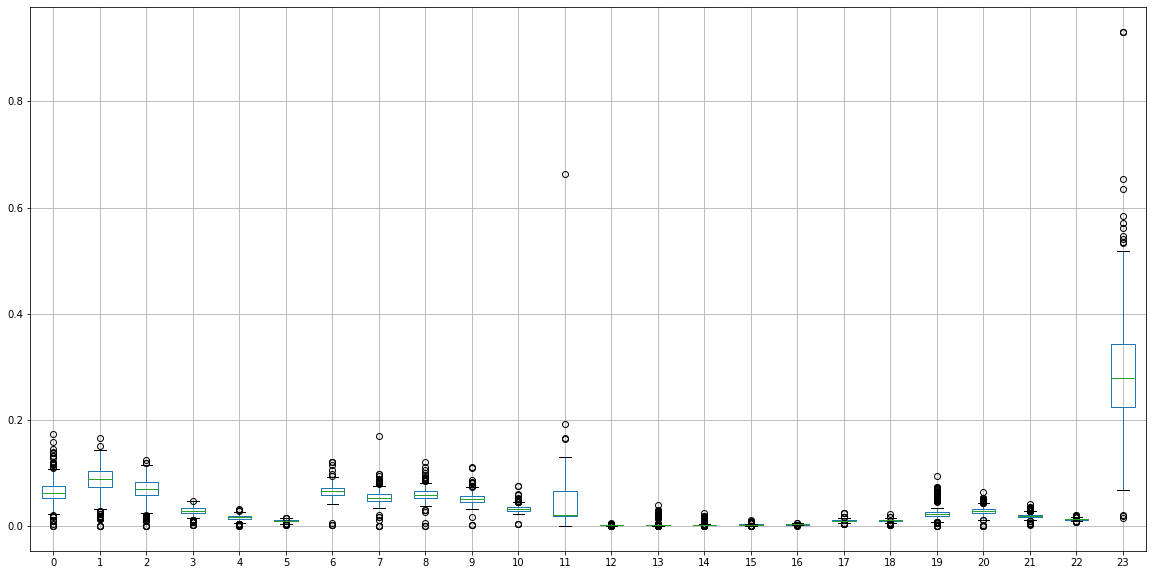

In [109]:
real_liver.div(real_liver.sum(axis=0), axis=1).T.boxplot(figsize=(20,10))

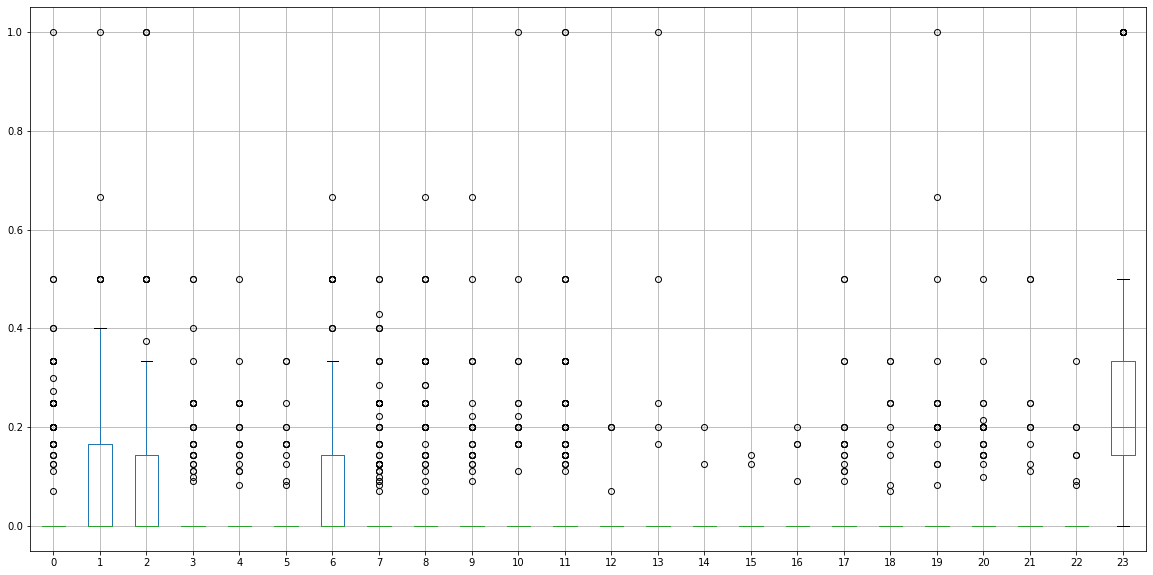

In [110]:
simulated_liver.div(simulated_liver.sum(axis=0), axis=1).T.boxplot(figsize=(20,10))

In [111]:
real_liver_mean = real_liver.div(real_liver.sum(axis=0), axis=1).mean(axis=1)

In [112]:
simulated_liver_mean = simulated_liver.div(simulated_liver.sum(axis=0), axis=1).mean(axis=1)

In [113]:
cosine_similarity([real_liver_mean.tolist(), simulated_liver_mean.tolist()])

array([[1.       , 0.9886028],
       [0.9886028, 1.       ]])

<BarContainer object of 24 artists>

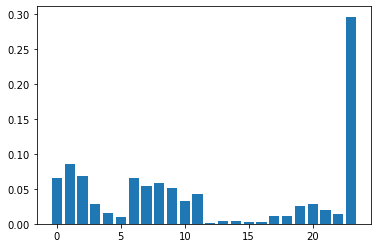

In [115]:
plt.bar(range(24), real_liver_mean.tolist())

<BarContainer object of 24 artists>

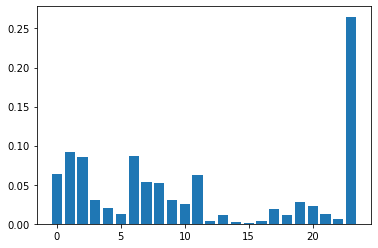

In [116]:
plt.bar(range(24), simulated_liver_mean.tolist())

Skin-Melanoma